# Packages, Heaviside- Funktion und Funktion der jeweils neuen Beschleunigung

In [1]:
using PyPlot           ; println("geladen: PyPlot")
using PyCall           ; println("geladen: PyCall")
using Colors           ; println("geladen: Colors")
using Dates            ; println("geladen: Dates")
using CSV              ; println("geladen: CSV")

using DataFrames       ; println("geladen: DataFrames")
using ProgressMeter    ; println("geladen: ProgressMeter")
using InteractiveUtils ; println("geladen: InteractiveUtils")
using Statistics       ; println("geladen: Statistics")
using LinearAlgebra    ; println("geladen: LinearAlgebra")
#using Interpolations   ; println("Interpolations geladen")

@pyimport matplotlib.colors as mcolors ; println("importiert: matplotlib.colors as mcolors")
@pyimport matplotlib.ticker as ticker  ; println("importiert: matplotlib.ticker as ticker")
println("done")
#npt - inputs
#oup - outputs
#pth - paths
#ctp - control parameters   #inpt #outp #pths #clpr

geladen: PyPlot
geladen: PyCall
geladen: Colors
geladen: Dates
geladen: CSV
geladen: DataFrames
geladen: ProgressMeter
geladen: InteractiveUtils
geladen: Statistics
geladen: LinearAlgebra
importiert: matplotlib.colors as mcolors
importiert: matplotlib.ticker as ticker
done


# Funktionen

In [2]:
function Zeitentw_Funk(oup, npt)
    
    ####################################################################################
    ### Variablen und Kontrollparameter initialisieren
    ####################################################################################

    last_t_Index           = Int64(round(npt[:t_end]/npt[:t_step_sim]))
    n_t_steps_per_sim_unit = Int64(round(npt[:t_step_plot] / npt[:t_step_sim]))

    n_t_steps_reaction     = Int64(round(npt[:τ_reaction] / npt[:t_step_sim]))
    n_t_steps_oa_delay     = Int64(round(npt[:τ_oa_delay] / npt[:t_step_sim]))
    println("npt[:τ_reaction] = $npt[:τ_reaction] , n_t_steps_reaction = $n_t_steps_reaction")

    ctp = Dict(  #control_parameter
        :new_car   => 0.0,
        :zub1_nflx => 0.0, # Kontrolliert die Zugabe neuer Autos in den Zubringer
        :zub2_nflx => 0.0,
        :zub1_res  => [],  # Reservoir der Autos, die im Zubrigner, aber noch nicht auf der Strecke sind
        :zub2_res  => []
        )

    pInd = Dict( #positions_Index
        :z11 => 0,
        :z12 => 0,
        :z21 => 0,
        :z22 => 0
        )

    #################################################################################
    ### Anfagszustand initialisieren
    #################################################################################
    initial_distance           = npt[:v_init] / npt[:q_in]
    Rest                       = mod(npt[:L_track], initial_distance)
    first_car_loc              = npt[:L_track] - Rest
    oup[:N_initial_occupation] = Int64(round(((npt[:L_track] - Rest)/initial_distance + 1)))
    oup[:new_car_n]            = oup[:N_initial_occupation]
    println("first_car_loc = $first_car_loc")
    println("initial_distance = $initial_distance")
    println("oup[:N_initial_occupation] = $(oup[:N_initial_occupation])")
    #oup[:N_initial_occupation] = N_initial_occupation

    #############################################################
    ### initial-acceleration berechnen
    #############################################################
    oup[:total_cars_from_q_in] = oup[:N_initial_occupation] + Int(floor(npt[:q_in] * npt[:t_end]))

    upscaled             = Int(10^ceil(log(10 , oup[:total_cars_from_q_in])))
    total_cars_from_zub2 = Int(floor(npt[:q_zub][:q21] * npt[:t_zub][:b2_duration]))
    len_accel_vec_in     = 2 * upscaled + total_cars_from_zub2
    for index in 1 : len_accel_vec_in
        if index ≤ oup[:N_initial_occupation]
            
            push!(oup[:accel_vec_in] , make_init_accel_vals_func(
                    [0, initial_distance], [npt[:v_init], npt[:v_init]], 1, npt, (n_t_steps_reaction + 1)))
            push!(oup[:over_accel_vec_in], Any[0.0 for _ in 1 : (n_t_steps_oa_delay + 1)])
        else
            push!(oup[:accel_vec_in] , [])
            push!(oup[:over_accel_vec_in] , [])
        end
        push!(oup[:over_accel_cp_vec], 0.0)
    end
    #############################################################
    ### Ende: initial-acceleration berechnen
    #############################################################
    
    # monitoring des overacceleration-Parameters bzw. der Acceleration initialisieren
    if npt[:monitoring_oa_switch] == 1
        oup[:cpara_monitoring_oa] = [[] for _ in 1 : oup[:N_initial_occupation]]
        oup[:accel_monitoring_oa] = [[] for _ in 1 : oup[:N_initial_occupation]]
    end
    
    # vehicle numbers der zubringer initialisieren
    oup[:n_new_car_in_zub1]     = 1 * upscaled # 1 * number2
    oup[:n_new_car_in_zub2]     = 2 * upscaled # 2 * number2
    
    push!(oup[:t_vec_in], 0)
    for index_initials in 1 : oup[:N_initial_occupation]
        insert!(oup[:s_vec_in][1],     1, first_car_loc - (index_initials - 1) * initial_distance)
        insert!(oup[:v_vec_in][1],     1, npt[:v_init])
        insert!(oup[:g_vec_in][1],     1, initial_distance - npt[:d_par]) # neu 6.6.2024 Peter Lustig
        insert!(oup[:veh_n_vec_in][1], 1, index_initials)
    end #f48

    #############################################################
    ### Positions-Indizes bestimmen
    #############################################################
    for pos_I in 1 : oup[:N_initial_occupation]
        runback_Index = oup[:N_initial_occupation] + 1 - pos_I
        if pInd[:z11] == 0 || pInd[:z12] == 0 || pInd[:z21] == 0 || pInd[:z22] == 0
        
            if oup[:s_vec_in][1][runback_Index] < npt[:x_zub][:x22] && pInd[:z22] == 0
                pInd[:z22] = runback_Index

            elseif oup[:s_vec_in][1][runback_Index] < npt[:x_zub][:x21] && pInd[:z21] == 0
                pInd[:z21] = runback_Index # siehe Referenz x1

            elseif oup[:s_vec_in][1][runback_Index] < npt[:x_zub][:x12] && pInd[:z12] == 0
                pInd[:z12] = runback_Index # siehe Referenz x1

            elseif oup[:s_vec_in][1][runback_Index] < npt[:x_zub][:x11] && pInd[:z11] == 0
                pInd[:z11] = runback_Index # siehe Referenz x1
            end #i54
        else
            break
        end
    end
    println("Zu Beginn der Simulation ist")
    println("pInd[:z11] = $(pInd[:z11]) , oup[:s_vec_in][1][pInd[:z11]] = $(oup[:s_vec_in][1][pInd[:z11]])")
    println("pInd[:z12] = $(pInd[:z12]) , oup[:s_vec_in][1][pInd[:z12]] = $(oup[:s_vec_in][1][pInd[:z12]])")
    println("pInd[:z21] = $(pInd[:z21]) , oup[:s_vec_in][1][pInd[:z21]] = $(oup[:s_vec_in][1][pInd[:z21]])")
    println("pInd[:z22] = $(pInd[:z22]) , oup[:s_vec_in][1][pInd[:z22]] = $(oup[:s_vec_in][1][pInd[:z22]])")

    ####################################################################################
    ### Zeitentwicklung durchführen
    ####################################################################################
    for t_Index in 1 : last_t_Index #t_first_in_unit : t_last_in_unit
        
        time      = round(t_Index*npt[:t_step_sim], digits = 2)
        t_ArIndex = length(oup[:s_vec_in]) + 1# neu 9.7.2024
        oup[:time] = deepcopy(time)
        
        push!(oup[:t_vec_in]     , time)
        push!(oup[:s_vec_in]     , deepcopy(oup[:s_vec_in][t_ArIndex - 1]))
        push!(oup[:v_vec_in]     , deepcopy(oup[:v_vec_in][t_ArIndex - 1]))
        push!(oup[:g_vec_in]     , deepcopy(oup[:g_vec_in][t_ArIndex - 1]))
        push!(oup[:veh_n_vec_in] , deepcopy(oup[:veh_n_vec_in][t_ArIndex - 1]))

        ######################################################################################################
        ### neue Beschleunigung berechnen
        ######################################################################################################
        oup = new_accel_func(oup, npt, t_ArIndex - 1)
        
        # a_values(t) = f(s_values(t), v_values(t))
        # v(t+1) = v(t) + a(t) * Δt
        # v(t+1) = v(t) + a(t) * Δt
        #######################################################################################################
        ### neue Geschwindigkeit berechnen
        #######################################################################################################
        
        for pos_Index in 1 : length(oup[:s_vec_in][t_ArIndex - 1])
            car_number   = oup[:veh_n_vec_in][t_ArIndex - 1][pos_Index]

            over_acceleration = oup[:over_accel_vec_in][car_number][1]
            # Die Beschleunigungsleistung des Motors ist durch a_max limitiert!
            acceleration = min(oup[:accel_vec_in][car_number][1]+oup[:over_accel_vec_in][car_number][1] , npt[:a_max])
            if (npt[:monitoring_oa_switch] == 1 &&
                npt[:monitoring_oa_first_car] ≤ car_number ≤ oup[:N_initial_occupation] && 
                time ≤ npt[:monitoring_oa_duration])
                push!(oup[:accel_monitoring_oa][car_number] , acceleration)
            end

            vel = oup[:v_vec_in][t_ArIndex - 1][pos_Index] + npt[:t_step_sim] * acceleration
            
            if npt[:oa_in_fflow_switch] == 1 && over_acceleration > 0
                vel_cor = max(npt[:v_min] , min(vel , npt[:v_max_exception])) # Maximum:140 km/h !!!!
    
            elseif (npt[:oa_in_fflow_switch] == 1 && over_acceleration == 0 &&
                    oup[:v_vec_in][t_ArIndex - 1][pos_Index] > npt[:v_max])
                #vel_cor = max(npt[:v_min] , min(vel , npt[:v_max]))
                vel_cor = max(npt[:v_min] , min(vel , npt[:v_max_exception])) # Peter Lustig 20.7.2024
                
            else #wenn npt[:oa_in_fflow_switch]==1 bzw. wenn(npt[:oa_in_fflow_switch]==0, oa==0 und v≤v_max)
                vel_cor = max(npt[:v_min] , min(vel , npt[:v_max])) # Maximum:120 km/h !!!!

            end
            
            oup[:v_vec_in][t_ArIndex][pos_Index] = vel_cor
        end #f110
        
        ######################################################################################################
        ### neuen Ort berechnen
        ######################################################################################################
        for pos_Index in 1:length(oup[:s_vec_in][t_ArIndex - 1])
            loc = oup[:s_vec_in][t_ArIndex - 1][pos_Index] + (
                npt[:t_step_sim] * oup[:v_vec_in][t_ArIndex - 1][pos_Index])
            oup[:s_vec_in][t_ArIndex][pos_Index] = loc
        end #f118
        if pInd[:z22] > length(oup[:s_vec_in][t_ArIndex])
            println("Oh! pos_Index_zub2p2 liegt außerhalb der Strecke\n"*
                "time = $time, npt[:t_end] = $npt[:t_end], pos_Index_zub2p2 = $(pInd[:z22]), "*
                "length(oup[:s_vec_in][t_ArIndex]) = $(length(oup[:s_vec_in][t_ArIndex]))")
        end # diese 4 print-Zeilen sind vom 15.6.2024 Walter

        
        ##########################################################################
        ### Index-Aktualisierung Nr. 1
        ##########################################################################
        actualize_pos_Indices_func(oup, npt, pInd, t_ArIndex)
        ##########################################################################

        ######################################################################################################
        ### Autos am Ende der Straße entfernen (oberes Ende der Straße)
        ######################################################################################################
        for pos_Index in 1:length(oup[:s_vec_in][t_ArIndex])
            back_run_Index = length(oup[:s_vec_in][t_ArIndex]) + 1 - pos_Index
            if oup[:s_vec_in][t_ArIndex][back_run_Index] > npt[:L_track]
                pop!(oup[:s_vec_in][t_ArIndex])
                pop!(oup[:v_vec_in][t_ArIndex])
                pop!(oup[:g_vec_in][t_ArIndex])
                #emitted_car = oup[:veh_n_vec_in][t_ArIndex][length(oup[:veh_n_vec_in][t_ArIndex])]
                emitted_car = oup[:veh_n_vec_in][t_ArIndex][end]
                oup[:accel_vec_in][emitted_car] = []
                oup[:over_accel_vec_in][emitted_car] = []
                pop!(oup[:veh_n_vec_in][t_ArIndex])
            elseif oup[:s_vec_in][t_ArIndex][back_run_Index] ≤ npt[:L_track]
                break
            end #i141
        end #f139
        ######################################################################################################
        ### neue Autos auf die Straße setzen (am unteren Ende der Straße)
        ######################################################################################################
        ctp[:new_car] = ctp[:new_car] + npt[:q_in] * npt[:t_step_sim]
        if ctp[:new_car] ≥ 1
            oup[:new_car_n] = oup[:new_car_n] + 1

            # Auto einsetzen
            insert!(oup[:s_vec_in][t_ArIndex],     1, 0)
            insert!(oup[:v_vec_in][t_ArIndex],     1, npt[:v_init])
            insert!(oup[:veh_n_vec_in][t_ArIndex], 1, oup[:new_car_n])
            
            oup[:accel_vec_in][oup[:new_car_n]]      = make_init_accel_vals_func(
                oup[:s_vec_in][t_ArIndex], oup[:v_vec_in][t_ArIndex], 1, npt, (n_t_steps_reaction + 1))
            oup[:over_accel_vec_in][oup[:new_car_n]] = Any[0.0 for _ in 1 : (n_t_steps_oa_delay + 1)]
            
            g_headway = oup[:s_vec_in][t_ArIndex][2] - npt[:d_par] # geändert 17.7.2024
            insert!(oup[:g_vec_in][t_ArIndex], 1, g_headway)       # geändert 17.7.2024

            pInd[:z11] += 1
            pInd[:z12] += 1
            pInd[:z21] += 1
            pInd[:z22] += 1

            ctp[:new_car] -= 1
        end #i156
        #########################################################################################################
        ### neue Autos von Zubringer Zub1 ("bottleneck b") auf die Straße setzen
        #########################################################################################################        
        #npt[:q_zub][:q10]
        if time ≥ npt[:t_zub][:b1_start]
            #ctp[:zub1_nflx] = ctp[:zub1_nflx] + npt[:q_zub][:q11] * npt[:t_step_sim]
            ctp[:zub1_nflx] += npt[:q_zub][:q11] * npt[:t_step_sim]
            if ctp[:zub1_nflx] ≥ 1
                oup[:n_new_car_in_zub1] += 1
                push!(ctp[:zub1_res] , oup[:n_new_car_in_zub1])
                #ctp[:zub1_nflx] = ctp[:zub1_nflx] - 1
                ctp[:zub1_nflx] -= 1
            end #i176
        end
        if length(ctp[:zub1_res]) > 0
            # Einfügebefehl Auo vom Zubringer Zub1 auf die Straße
            for Ortsindex in pInd[:z11] : pInd[:z12]
                if oup[:s_vec_in][t_ArIndex][Ortsindex + 1] - oup[:s_vec_in][t_ArIndex][Ortsindex]-2*npt[:d_par] > (
                        npt[:λ_b] * oup[:v_vec_in][t_ArIndex][Ortsindex + 1]) > 0
                    loc = (oup[:s_vec_in][t_ArIndex][Ortsindex + 1] + oup[:s_vec_in][t_ArIndex][Ortsindex]) / 2

                    if npt[:x_zub][:x11] ≤ loc ≤ npt[:x_zub][:x12]
                        velocity   = oup[:v_vec_in][t_ArIndex][Ortsindex+1]
                        car_number = ctp[:zub1_res][1]
                        deleteat!(ctp[:zub1_res] , 1)

                        insert!(oup[:s_vec_in][t_ArIndex],     (Ortsindex + 1), loc)
                        insert!(oup[:v_vec_in][t_ArIndex],     (Ortsindex + 1), velocity)
                        insert!(oup[:g_vec_in][t_ArIndex],     (Ortsindex + 1), 0)
                        insert!(oup[:veh_n_vec_in][t_ArIndex], (Ortsindex + 1), car_number)

                        oup[:accel_vec_in][car_number]      = make_init_accel_vals_func(oup[:s_vec_in][t_ArIndex], 
                            oup[:v_vec_in][t_ArIndex], Ortsindex+1, npt, (n_t_steps_reaction + 1))
                        oup[:over_accel_vec_in][car_number] = Any[0.0 for _ in 1 : (n_t_steps_oa_delay + 1)]

                        # Zubringerpositionen aktualisieren
                        pInd[:z21] += 1
                        pInd[:z22] += 1
                        if loc < oup[:s_vec_in][t_ArIndex][pInd[:z12]]
                            pInd[:z12] += 1
                        end #i200
                    end #i187
                end #i184
                if length(ctp[:zub1_res]) == 0
                    break
                end #i205
            end #f183
        end #i181
        ######################################################################################################
        ### neue Autos von Zubringer Zub2 ("bottleneck b_down") auf die Straße setzen
        ######################################################################################################
        if npt[:t_zub][:b2_start] ≤ time ≤ (npt[:t_zub][:b2_start] + npt[:t_zub][:b2_duration])
            #ctp[:zub2_nflx] = ctp[:zub2_nflx] + npt[:q_zub][:q21] * npt[:t_step_sim]
            ctp[:zub2_nflx] += npt[:q_zub][:q21] * npt[:t_step_sim]
            if ctp[:zub2_nflx] ≥ 1
                oup[:n_new_car_in_zub2] += 1
                push!(ctp[:zub2_res] , oup[:n_new_car_in_zub2])
                #ctp[:zub2_nflx] = ctp[:zub2_nflx] - 1
                ctp[:zub2_nflx] -= 1
            end #i215
        end #i213 #############################################################################################
        if length(ctp[:zub2_res]) > 0

            # Einfügebefehl Auto vom Zubringer Zub2 auf die Straße
            for Ortsindex in pInd[:z21] : pInd[:z22]

                if oup[:s_vec_in][t_ArIndex][Ortsindex + 1] - oup[:s_vec_in][t_ArIndex][Ortsindex]-2*npt[:d_par] > (
                        npt[:λ_b] * oup[:v_vec_in][t_ArIndex][Ortsindex + 1]) > 0
                    loc = (oup[:s_vec_in][t_ArIndex][Ortsindex + 1] + oup[:s_vec_in][t_ArIndex][Ortsindex]) / 2

                    if npt[:x_zub][:x21] ≤ loc ≤ npt[:x_zub][:x22]
                        velocity     = oup[:v_vec_in][t_ArIndex][Ortsindex+1]
                        #acceleration = 0
                        car_number   = ctp[:zub2_res][1]
                        deleteat!(ctp[:zub2_res] , 1)

                        insert!(oup[:s_vec_in][t_ArIndex],         (Ortsindex + 1), loc)
                        insert!(oup[:v_vec_in][t_ArIndex],         (Ortsindex + 1), velocity)
                        insert!(oup[:g_vec_in][t_ArIndex],         (Ortsindex + 1), 0)
                        insert!(oup[:veh_n_vec_in][t_ArIndex],     (Ortsindex + 1), car_number)

                        oup[:accel_vec_in][car_number]      = make_init_accel_vals_func(oup[:s_vec_in][t_ArIndex], 
                            oup[:v_vec_in][t_ArIndex], Ortsindex+1, npt, (n_t_steps_reaction + 1))
                        
                        oup[:over_accel_vec_in][car_number] = Any[0.0 for _ in 1 : (n_t_steps_oa_delay + 1)]
            

                        # Zubringerpositionen aktualisieren
                        if loc < oup[:s_vec_in][t_ArIndex][pInd[:z22]]
                            pInd[:z22] += 1
                        end #i241
                    end #i230
                end #i227
                if length(ctp[:zub2_res]) == 0
                    break
                end #i246
            end #f226
        end #i221
        
        ##########################################################################
        ### Analyse nach jedem Zeitschritt
        ##########################################################################
        if length(oup[:v_vec_in][end]) ≠ length(oup[:g_vec_in][end])
           println("Zeitentw.funktion: Längen von g und v_vec_in stimmen nicht überein.\n"*
                "Länge g = $(length(oup[:g_vec_in][end]))"*
                "Länge v = $(length(oup[:v_vec_in][end]))\n"*
                "time = $time\n") 
        end

        ########################################
        ### Export-Variablen befüllen
        ########################################
        if mod(t_Index , n_t_steps_per_sim_unit) == 0
             # length(oup[:t_vec_in])
            push!(oup[:t_vec_ex] , oup[:t_vec_in][t_ArIndex])
            
            for str in ["s_vec_", "v_vec_", "g_vec_"]
                push!(oup[Symbol(str*"ex")] ,
                (t_Index<last_t_Index ? oup[Symbol(str*"in")][t_ArIndex] : oup[Symbol(str*"in")][t_ArIndex-1]))
            end
            # g_vec_in bekommt immer seine Einträge über die accel-function => einen Schritt verzögert
            # s und v dürfen nicht mehr einträge als g haben, daher werden beim letzten t-schritt der Sim
            # die s,v und g-Werte von t-1 hinzugefüht.
            
            if length(oup[:v_vec_ex][end]) ≠ length(oup[:g_vec_ex][end])
               println("Zeitentw.funktion: Längen von g und v_vec_ex stimmen nicht überein.\n"*
                    "Länge g = $(length(oup[:g_vec_ex][end]))"*
                    "Länge v = $(length(oup[:v_vec_ex][end]))\n"*
                    "time = $time\n") 
            end
            #push!(oup[:veh_n_vec_in]_ex_var , oup[:veh_n_vec_in][t_ArIndex])
        end
        ##########################################################################
        ### Extrema und Mittelwerte von v und g berechnen
        ##########################################################################
        if t_Index ≠ last_t_Index
            oup[:vmin] = min(oup[:vmin] , minimum(oup[:v_vec_in][t_ArIndex])) # Index t_ArIndex ist der ...
            oup[:vmax] = max(oup[:vmax] , maximum(oup[:v_vec_in][t_ArIndex])) # ... letzte editierte Index von g
        end
        oup[:gmin] = min(oup[:gmin] , minimum(oup[:g_vec_in][t_ArIndex - 1])) # Index t_ArIndex-1 ist der ...
        oup[:gmax] = max(oup[:gmax] , maximum(oup[:g_vec_in][t_ArIndex - 1])) # ... letzte editierte Index von g
        
        # g_mean berechnen
        oup[:g_mean_val] += sum(oup[:g_vec_in][t_ArIndex - 1])#Index t_ArIndex-1 ist der letzte editierte Index von g
        oup[:sum_all_occupations_for_g_mean] += length(oup[:g_vec_in][t_ArIndex - 1])
        # v_mean berechnen
        oup[:v_mean_val] += sum(oup[:v_vec_in][t_ArIndex]) #Index t_ArIndex ist der letzte editierte Index von v
        oup[:sum_all_occupations_for_v_mean] += length(oup[:v_vec_in][t_ArIndex])
        
        ##########################################################################
        ### Optional: Monitoring von road occupation und g-sum
        ##########################################################################
        # Anzahl der Autos auf der Straße messen
        if npt[:monitoring_road_occ_shift] == 1
            road_occ_by_cars = length(oup[:veh_n_vec_in][end])
            push!(oup[:road_occ_over_time] , road_occ_by_cars)
        end
        # Summe der g-headways bei t = time - npt[:t_step_sim] messen
        if npt[:monitoring_g_sum_shift] == 1
            oup[:g_vec_in][t_ArIndex - 1][end] = npt[:L_track] - oup[:s_vec_in][t_ArIndex - 1][end]
            recent_road_occ_by_cars = length(oup[:veh_n_vec_in][end-1])
            push!(oup[:g_sum_vec] , sum(oup[:g_vec_in][t_ArIndex - 1]) + recent_road_occ_by_cars * npt[:d_par] +
            oup[:s_vec_in][t_ArIndex - 1][1])
        end
        
        ##########################################################################
        ### Index-Aktualisierung Nr. 2 zur Sicherheit - 23.6.2024
        ##########################################################################
        actualize_pos_Indices_func(oup, npt, pInd, t_ArIndex)
        
        ##########################################################################
        ### Orte der Zubringer-Indizes messen - pro Zeitschritt
        ##########################################################################
        if npt[:monitoring_crictical_cars_by_zub_locations_switch] == 1
            measure_loc_of_pos_Indices_func(oup, pInd, t_ArIndex) #if mod(t_Index, 5) == 0 ... #end
        end
        
        # Maxima und Minima der Orte der Positions-Indizes (inklusive der jeweils folgenden Position)
        # t-schrittweise aktualisieren
        # - alternativ ließen sich auch die Extrema von oup[:zub_loc_p_vec1] am ende der Zeitentwicklung messen
        actualize_min_max_loc_of_pos_Indices_func(oup, pInd, t_ArIndex, time)
        
        if t_Index ≥ n_t_steps_per_sim_unit + 1
            # + 1 hinzugefpgt, um alle oup[:g_vec_in] Werte in potential_oup[:gmin]_vec auszuwerten
            deleteat!(oup[:t_vec_in] , 1)
            deleteat!(oup[:s_vec_in] , 1)
            deleteat!(oup[:v_vec_in] , 1)
            deleteat!(oup[:g_vec_in] , 1)
            deleteat!(oup[:veh_n_vec_in] , 1)        
        end
        
        #if npt[:monitoring_fill_zub_shift] == 1
        if npt[:monitoring_filling_levels_of_bnecks_shift] == 1    
            if time ≥ npt[:t_zub][:b1_start]
                push!(oup[:zub1_filling_level] , length(ctp[:zub1_res]))
            end
            if npt[:t_zub][:b2_start] ≤ time ≤ (npt[:t_zub][:b2_start] + 1.1 * npt[:t_zub][:b2_duration])
                push!(oup[:zub2_filling_level] , length(ctp[:zub2_res]))
            end
        end
    end #f78 Ende der Zeitschleife

    oup[:n_new_car_in_zub2] -= length(ctp[:zub2_res])
    oup[:n_new_car_in_zub1] -= length(ctp[:zub1_res])
    # Damit der ausgegebene Wert auch tatsächlich der Anzahl der Autos, die die Straße von Zubringer b aus
    # erreicht haben, entspricht.
    
    oup[:total_cars_from_zub1] = oup[:n_new_car_in_zub1] - 1 * upscaled
    oup[:total_cars_from_zub2] = oup[:n_new_car_in_zub2] - 2 * upscaled
    
    oup[:t_vec_in]          = []
    oup[:s_vec_in]          = [[]]
    oup[:v_vec_in]          = [[]]
    oup[:g_vec_in]          = [[]]
    oup[:veh_n_vec_in]      = [[]]
    oup[:accel_vec_in]      = []
    oup[:over_accel_vec_in] = []
    return oup
    println("\n"*"oup[:list_yet_monitored_cars_acc] = $(oup[:list_yet_monitored_cars_acc])\n")
end

Zeitentw_Funk (generic function with 1 method)

In [3]:
testy = [1,2,3,4]
last(testy) , testy[end]
testy2 = [[1,1],[2,2],[3,3]]
last(testy2) , testy2[end]

testy3 = [1,2,3,4] ; testy4 = [2,2,2,2]
sum(testy3 .* testy4)

20

In [4]:
# Maxima und Minima der Orte der Positions-Indizes (inklusive der jeweils folgenden Position)
# t-schrittweise aktualisieren
function actualize_min_max_loc_of_pos_Indices_func(oup, pInd, t_ArIndex, time)
    for loop_index in 1:16
        string_name, nr3, nr4 = get_my_string_and_info_func(loop_index)

        position_index   = pInd[Symbol(string_name)] #var_dict[string_name]
        position_index   = ifelse(nr3 == 1, position_index, position_index + 1)
        loc_to_check     = oup[:s_vec_in][t_ArIndex][position_index]
        loc_saved_so_far = oup[:min_max_loc_of_pos_Indices][loop_index]

        if nr4 == 1
            new_location = min(loc_saved_so_far , loc_to_check)
        elseif nr4 == 2
            new_location = max(loc_saved_so_far , loc_to_check)
        end
        oup[:min_max_loc_of_pos_Indices][loop_index] = new_location

        if oup[:min_max_loc_of_pos_Indices][loop_index] ≠ oup[:min_max_loc_of_pos_Indices_alt][loop_index]
            oup[:min_max_loc_of_pos_Indices_time][loop_index] = time
        end
        oup[:min_max_loc_of_pos_Indices_alt][loop_index] = deepcopy(oup[:min_max_loc_of_pos_Indices][loop_index])
    end
end
#########################################################################################################
function measure_loc_of_pos_Indices_func(oup, pInd, t_ArIndex)
    location1 = Int64(round(oup[:s_vec_in][t_ArIndex][pInd[:z11]]  ))
    location2 = Int64(round(oup[:s_vec_in][t_ArIndex][pInd[:z11]+1]))
    location3 = Int64(round(oup[:s_vec_in][t_ArIndex][pInd[:z12]]  ))
    location4 = Int64(round(oup[:s_vec_in][t_ArIndex][pInd[:z12]+1]))

    location5 = Int64(round(oup[:s_vec_in][t_ArIndex][pInd[:z21]]  ))
    location6 = Int64(round(oup[:s_vec_in][t_ArIndex][pInd[:z21]+1]))
    location7 = Int64(round(oup[:s_vec_in][t_ArIndex][pInd[:z22]]  ))
    location8 = Int64(round(oup[:s_vec_in][t_ArIndex][pInd[:z22]+1]))

    push!(oup[:zub_loc_p_vec1][1] , location1)
    push!(oup[:zub_loc_p_vec1][2] , location2)
    push!(oup[:zub_loc_p_vec1][3] , location3)
    push!(oup[:zub_loc_p_vec1][4] , location4)

    push!(oup[:zub_loc_p_vec1][5] , location5)
    push!(oup[:zub_loc_p_vec1][6] , location6)
    push!(oup[:zub_loc_p_vec1][7] , location7)
    push!(oup[:zub_loc_p_vec1][8] , location8)
end
##########################################################################################
function actualize_pos_Indices_func(oup, npt, pInd, t_ArIndex)
    ### kritische Indizes der merging Area aktualisieren - Vorwärtsfahrt
    if oup[:s_vec_in][t_ArIndex][pInd[:z22]] > npt[:x_zub][:x22]
        pInd[:z22] -= 1 # = pos_Index_zub2p2 - 1
    end #i124
    if oup[:s_vec_in][t_ArIndex][pInd[:z21]] > npt[:x_zub][:x21]
        pInd[:z21] -= 1 # = pos_Index_zub2p1 - 1
    end #i127
    if oup[:s_vec_in][t_ArIndex][pInd[:z12]] > npt[:x_zub][:x12]
        pInd[:z12] -= 1 # = pos_Index_zub1p2 - 1
    end #i130
    if oup[:s_vec_in][t_ArIndex][pInd[:z11]] > npt[:x_zub][:x11]
        pInd[:z11] -= 1 # = pos_Index_zub1p1 - 1
    end #i133


    ### kritische Indizes der merging Area aktualisieren - Rückwärtsfahrt, hinzugefügt am 19.6.2024
    if oup[:s_vec_in][t_ArIndex][pInd[:z22] + 1] ≤ npt[:x_zub][:x22]
        pInd[:z22] += 1 # = pos_Index_zub2p2 + 1
    end #i124
    if oup[:s_vec_in][t_ArIndex][pInd[:z21] + 1] ≤ npt[:x_zub][:x21]
        pInd[:z21] += 1 # = pos_Index_zub2p1 + 1
    end #i127
    if oup[:s_vec_in][t_ArIndex][pInd[:z12] + 1] ≤ npt[:x_zub][:x12]
        pInd[:z12] += 1 # = pos_Index_zub1p2 + 1
    end #i130
    if oup[:s_vec_in][t_ArIndex][pInd[:z11] + 1] ≤ npt[:x_zub][:x11]
        pInd[:z11] += 1 # = pos_Index_zub1p1 + 1
    end #i133
end
####################################################################################################
function get_my_string_and_info_func(number)
    nr1v = Int(ceil(number / 8.0)) ; zw1 = number - (nr1v-1)*8
    nr2v = Int(ceil(zw1 / 4.0))    ; zw2 = zw1 - (nr2v-1)*4
    nr3v = Int(ceil(zw2 / 2.0))    ; zw3 = zw2 - (nr3v-1)*2
    nr4v = Int(ceil(zw3 / 1.0))
    #nr4v = 1 => min #nr4v = 2 => max ----------- #nr3v = 1 => Index + 0 #nr3v = 2 => Index +1
    my_string_var = "z$nr1v$nr2v"
    return my_string_var, nr3v, nr4v
end
####################################################################################################
function heaviside(x)
    if x ≥ 0
        return 1
    elseif x < 0
        return 0
    else return NaN
    end
end
##########################################################################
### Beschleunigungsfunktionen
##########################################################################
function new_accel_func(oup_v, npt_v, t_ArIndex2) # früher: new_accel_func_s2

    lens = length(oup_v[:s_vec_in][t_ArIndex2])
    for pos in 1 : lens

        car_number        = oup_v[:veh_n_vec_in][t_ArIndex2][pos]
        acceleration      = 0.0
        over_acceleration = 0.0
        
        if pos == lens
            acceleration = npt_v[:a_max]
            g_H = oup_v[:s_vec_in][t_ArIndex2][pos] - oup_v[:s_vec_in][t_ArIndex2][pos - 1] - npt_v[:d_par]
        else
            x_val   = oup_v[:s_vec_in][t_ArIndex2][pos]
            x_l_val = oup_v[:s_vec_in][t_ArIndex2][pos + 1]
            v_val   = oup_v[:v_vec_in][t_ArIndex2][pos]
            v_l_val = oup_v[:v_vec_in][t_ArIndex2][pos + 1]
            g_H     = x_l_val - x_val - npt_v[:d_par]
            
            # Verkehrsphase bestimmen
            traffic_phase = get_traffic_phase_func(npt_v, g_H, v_val)

            # jam
            if traffic_phase == "J"
                g_safe       = v_val * npt_v[:τ_safe]
                acceleration = min(npt_v[:p1] * (g_H - g_safe) + npt_v[:p2] * (v_l_val - v_val) , npt_v[:a_max])
            # Synchro
            elseif traffic_phase == "S"
                acceleration = min(npt_v[:p3] * (v_l_val - v_val) + npt_v[:p4] * heaviside(v_val - npt_v[:v_syn]),
                    npt_v[:a_max])
                if rand() < npt_v[:w1]
                    oup_v[:over_accel_cp_vec][car_number] += npt_v[:τ_over_acc]
                end
            # free flow
            else # das deckt τ_H > npt_v[:τ_G] bzw. traffic_phase == "F" ab.
                acceleration = npt_v[:a_max]
                if rand() < npt_v[:oa_in_fflow_switch] * npt_v[:w1] # hier ist der oa-in-ff-Schalter
                    oup_v[:over_accel_cp_vec][car_number] += npt_v[:τ_over_acc]
                end
            end
        end
        if oup_v[:over_accel_cp_vec][car_number] > 0
            over_acceleration += npt_v[:p5]
            oup_v[:over_accel_cp_vec][car_number] -= npt_v[:t_step_sim]
        end

        # Beschleunigungsvektor aktualisieren
        push!(    oup_v[:accel_vec_in][car_number]    , acceleration)
        deleteat!(oup_v[:accel_vec_in][car_number]    , 1)

        # Over-acceleration-Vektor aktualisieren
        push!(    oup_v[:over_accel_vec_in][car_number] , over_acceleration)
        deleteat!(oup_v[:over_accel_vec_in][car_number] , 1)

        # Monitoring-Werte speichern
        if (npt_v[:monitoring_oa_switch] == 1 &&
            npt_v[:monitoring_oa_first_car] ≤ car_number ≤ oup_v[:N_initial_occupation] && 
            oup_v[:time] ≤ npt_v[:monitoring_oa_duration])
            push!(oup_v[:cpara_monitoring_oa][car_number] , oup_v[:over_accel_cp_vec][car_number])
        end

        # g (Spatial-Headway) speichern
        oup_v[:g_vec_in][t_ArIndex2][pos] = g_H

        if (npt_v[:monitoring_oa_switch] == 1 && over_acceleration > 0 &&
            !(car_number in oup_v[:list_yet_monitored_cars_acc]))
            push!(oup_v[:list_yet_monitored_cars_acc] , car_number)
        end
    end
    return oup_v
end
####################################################################################################
function make_init_accel_vals_func(s_vec, v_vec, pos, npt_v, n_t_steps_reaction_var)

    acceleration = 0
    lens = length(s_vec)
    if pos == lens
        acceleration = npt_v[:a_max]
        g_H     = s_vec[pos] - s_vec[pos - 1] # Notlösung 6.6.2024 Peter Lustig - keine bessere in Sicht
    else
        x_val   = s_vec[pos]
        x_l_val = s_vec[pos + 1]
        v_val   = v_vec[pos]
        v_l_val = v_vec[pos + 1]
        g_H     = x_l_val - x_val - npt_v[:d_par]
        
        # Verkehrsphase bestimmen
        traffic_phase = get_traffic_phase_func(npt_v, g_H, v_val)

        # Beschleunigung bestimmen
        if traffic_phase == "J" #τ_H < npt_v[:τ_safe]
            g_safe       = v_val * npt_v[:τ_safe]
            acceleration = npt_v[:p1] * (g_H - g_safe) + npt_v[:p2] * (v_l_val - v_val)
        elseif traffic_phase == "S" #npt_v[:τ_safe] ≤ τ_H ≤ npt_v[:τ_G]
            acceleration = npt_v[:p3] * (v_l_val - v_val) + npt_v[:p4] * heaviside(v_val - npt_v[:v_syn])
        else # das deckt τ_H > npt_v[:τ_G] bzw. traffic_phase == "F" ab
            acceleration = npt_v[:a_max]
        end
        acceleration = min(acceleration, npt_v[:a_max])
    end
    
    init_accel_vec_var = [deepcopy(acceleration) for _ in 1 : (n_t_steps_reaction_var + 1)]
    return init_accel_vec_var
end
##################################################################################################
# Verkehrsphase bestimmen
function get_traffic_phase_func(npt_v, g_H, v_val_v)
    traffic_phase_v = 0
    if npt_v[:acc_fct_nr] == 1
        if g_H < npt_v[:τ_safe] * v_val_v
            traffic_phase_v = "J"
        elseif npt_v[:τ_safe] * v_val_v < g_H < npt_v[:τ_G] * v_val_v
            traffic_phase_v = "S"
        else # npt_v[:τ_G] * v_val < g_H
            traffic_phase_v = "F"
        end
    else # npt[:acc_fct_nr] == 2
        τ_H = g_H / v_val_v
        if τ_H < npt_v[:τ_safe]
            traffic_phase_v = "J"
        elseif npt_v[:τ_safe] < τ_H < npt_v[:τ_G]
            traffic_phase_v = "S"
        else # npt_v[:τ_G] < τ_H
            traffic_phase_v = "F"
        end
    end
    return traffic_phase_v
end
############################################################################
### Daten für den Color-Plot vorbereiten
#############################################################################
function create_plot_vals_func2(oup, string)
        #vals_vec::Symbol, 
        
    #in_variable = Symbol(string*"_vec_ex")
    #ex_variable = Symbol(string*"_plot")
    
    ex_variable = Symbol(string)                    # v_plot bzw. τ_H_plot
    in_variable = Symbol(string[1:end-5]*"_vec_ex") # v_vec_ex bzw. τ_H_vec_ex
    
    symbol_t = Symbol(ifelse(string == "v_plot" , "t_plot" , "τ_H_plot_t_vals"))
    symbol_s = Symbol(ifelse(string == "v_plot" , "s_plot" , "τ_H_plot_s_vals"))

    len_t_vals = length(oup[in_variable])
    for t_index in 1 : len_t_vals
        
        cars_on_track = length(oup[in_variable][t_index])

        for Pos_index in 1 : (cars_on_track - 1) # geändert 7.6.2024 Peter Lustig
            push!(oup[symbol_t]    , oup[:t_vec_ex][t_index])            # speichern in t_plot oder τ_H_plot_t_vals
            push!(oup[symbol_s]    , oup[:s_vec_ex][t_index][Pos_index]) # speichern in s_plot oder τ_H_plot_s_vals
            push!(oup[ex_variable] , oup[in_variable][t_index][Pos_index])
        end
        #:vplot, :τ_H_plot  
    end
    #return oup[:t_plot], oup[:s_plot], oup[ex_variable]
end
############################################################################################################
### plot
############################################################################################################
function plot_v_in_ts_plane_func(oup, npt, pth)
    
    #println("param_string_var_in =\n"*
    #    "$param_string_var_in") # test
    
    v_min_kmh = Int(round(3.6 * npt[:v_min]))
    v_max_kmh = Int(round(3.6 * npt[:v_max]))
        
    #p5_and_w1_string = replace("p5=$(npt[:p5]) w1=$(npt[:w1])", '.' => ',')
    
    #println("p5_and_w1_string = $p5_and_w1_string") # test
    
    figure(figsize=(18,12)) #(15,10) (6.4,5)
    scatter(oup[:t_plot], oup[:s_plot], c=oup[:v_plot], cmap="rainbow", marker=:s,
        #marker=:rect,
        s=1, linewidth=1)
    t_end_in_mins = npt[:t_end] / 60
    plot((0,t_end_in_mins), (npt[:x_zub][:x11]/1000, npt[:x_zub][:x11]/1000), "--", linewidth=0.5,
        
        label = oup[:param_string], color="k", alpha=0.5)
    plot((0,t_end_in_mins), (npt[:x_zub][:x12]/1000, npt[:x_zub][:x12]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    plot((0,t_end_in_mins), (npt[:x_zub][:x21]/1000, npt[:x_zub][:x21]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    plot((0,t_end_in_mins), (npt[:x_zub][:x22]/1000, npt[:x_zub][:x22]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    leg = legend(loc="center left")
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        text.set_color("black")  # Farbe der Legendenbeschriftung setzen
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end
    clim(v_min_kmh, v_max_kmh)
    colorbar(label="Geschwindigkeit [km/h]")

    # Achsentitel und Beschriftungen hinzufügen
    xlabel("Zeit [min]")
    ylabel("Ort [km]")
    title("Simulated Moving Synchronized Flow Pattern (MSP) \nColor-Plot von Zeit, Ort und Geschwindigkeit")

    filename2 = pth[:o1]*"/Colorplot MSP "*oup[:p5_and_w1_string]*" v1.png"
    filename3 = pth[:o2]*"/Colorplot MSP "*oup[:p5_and_w1_string]*" v1.png"
    
    #savefig(filename2 , bbox_inches="tight")
    #savefig(filename3 , bbox_inches="tight")
    close()
end
###################################################################################################
function plot_v_in_ts_plane_func2(oup, npt, pth)
        
    v_min_kmh = Int(round(3.6 * npt[:v_min]))
    v_max_kmh = Int(round(3.6 * npt[:v_max]))
    println("Test\n\nv_min_kmh = $v_min_kmh\nv_max_kmh = $v_max_kmh\n\n")
    #p5_and_w1_string = replace("p5=$(npt[:p5]) w1=$(npt[:w1])", '.' => ',')
    
    figure(figsize=(18,12)) #(15,10) (6.4,5)
    
    # Colormaps erstellen und kombinieren
    #colors1 = get_cmap("binary_r")(range(0.2, stop=0.8, length=30))
    colors1 = get_cmap("Blues_r")(range(0.2, stop=0.8, length=30))
    colors2 = get_cmap("gist_heat_r")(range(0.2, stop=0.8, length=120))
    colors  = vcat(colors1, colors2)

    # Neue Farbmappe erstellen
    mymap = mcolors.ListedColormap(colors, name="my_colormap")
    cmap1 = mcolors.ListedColormap(get_cmap(mymap).colors) # Andere cmaps?

    #bounds = [-30,-20, 0, 20, 40, 60, 80, 100, 120]
    bounds = collect(v_min_kmh:10: v_max_kmh)

    # Sicher stellen, dass oup[:v_plot] innerhalb der bounds liegt
    oup[:v_plot] = clamp.(oup[:v_plot], minimum(bounds), maximum(bounds))
    norm1 = mcolors.BoundaryNorm(bounds, cmap1.N) #- alternativ?
    
    plt.scatter(oup[:t_plot], oup[:s_plot], c=oup[:v_plot], cmap=mymap, marker="s",
        s=1,
        norm=norm1)
    
    v_step = 20
    ticks1 = collect(v_max_kmh : -v_step : v_min_kmh)
    ticks1 = reverse(ticks1)
    
    cbar = plt.colorbar(label="Geschwindigkeit [km/h]", 
        ticks = ticks1, spacing = "proportional")
    
    #=
    t_end_in_mins = npt[:t_end] / 60
    plt.plot((0,t_end_in_mins), (npt[:x_zub][:x11]/1000, npt[:x_zub][:x11]/1000), "--", linewidth=0.5,
        label = oup[:param_string], color="k", alpha=0.5)
    
    plt.plot((0,t_end_in_mins), (npt[:x_zub][:x12]/1000, npt[:x_zub][:x12]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)    
    plt.plot((0,t_end_in_mins), (npt[:x_zub][:x21]/1000, npt[:x_zub][:x21]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    plt.plot((0,t_end_in_mins), (npt[:x_zub][:x22]/1000, npt[:x_zub][:x22]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    =#
    
    for str in ["x11", "x12", "x21", "x22"]
        plt.plot((0, npt[:t_end] / 60), (npt[:x_zub][Symbol(str)] / 1000, npt[:x_zub][Symbol(str)] / 1000),
            "--", linewidth=0.5, color="k", alpha=0.5)
    end
    plt.plot((0,0), (0, 0), "--", linewidth=0.5, label = oup[:param_string], color="k", alpha=0.5)

    
    
    
    
    plt.clim(-30,120)

    # Achsentitel und Beschriftungen hinzufügen
    plt.xlabel("Zeit [min]")
    plt.ylabel("Ort [km]")
    plt.title("Simulated Moving Synchronized Flow Pattern (MSP) \nColor-Plot von Zeit, Ort und Geschwindigkeit")
    leg = plt.legend(loc="center left")
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        text.set_color("black")  # Farbe der Legendenbeschriftung setzen
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end    
    
    filename2 = pth[:o1]*"/Colorplot MSP "*oup[:p5_and_w1_string]*" v2.png"
    #savefig(filename2 , bbox_inches="tight")
    close()
end
######################################################################################
function plot_v_in_ts_plane_func2p2(oup, npt, pth)
        
    v_min_kmh = Int(round(3.6 * npt[:v_min]))
    v_max_kmh = Int(round(3.6 * npt[:v_max_exception]))

    # Daten für die max-velocitiy linien erzeugen
    #######################################################################################
    N_lines   = 3
    #######################################################################################
    t_factor  = 60
    s_factor  = 10^3

    lens               = npt[:L_track] / s_factor # Kilometer
    lent               = npt[:t_end] / t_factor   # Minute
    t_step2            = 10 * npt[:t_step_sim] / t_factor
    max_velocity_kmmin = npt[:v_max] * t_factor/s_factor   # m/s
    vert_shift         = lens / (N_lines)# ; println("vert_shift = $vert_shift")
    max_vel_line_t     = collect(t_step2 : t_step2 : lent)
    max_vel_line_s     = [mod.(max_vel_line_t * max_velocity_kmmin .+ index * vert_shift, lens)
        for index in 0 : (N_lines - 1)]

    for ind1 in 1 : N_lines
        for ind2 in 2 : (length(max_vel_line_t) - 1)
            if max_vel_line_s[ind1][ind2 - 1] < max_vel_line_s[ind1][ind2] > max_vel_line_s[ind1][ind2 + 1]
                max_vel_line_s[ind1][ind2] = NaN
            end
        end
    end
    
    figure(figsize=(18,12)) #(15,10) (6.4,5)
    
    # Colormaps erstellen und kombinieren
    #colors1 = get_cmap("binary_r")(range(0.2, stop=0.8, length=30))
    colors1 = get_cmap("Blues_r")(range(0.2, stop=0.8, length=30))
    colors2 = get_cmap("gist_heat_r")(range(0.2, stop=0.8, length=110))
    colors  = vcat(colors1, colors2)

    # Neue Farbmappe erstellen
    mymap = mcolors.ListedColormap(colors, name="my_colormap")
    cmap1 = mcolors.ListedColormap(get_cmap(mymap).colors) # Andere cmaps?
    bounds = collect(v_min_kmh : 10 : v_max_kmh)

    # Sicher stellen, dass oup[:v_plot] innerhalb der bounds liegt
    oup[:v_plot] = clamp.(oup[:v_plot], minimum(bounds), maximum(bounds))
    norm1 = mcolors.BoundaryNorm(bounds, cmap1.N) #- alternativ?
    
    ax1 = gca()
    scatter = ax1.scatter(oup[:t_plot], oup[:s_plot], c=oup[:v_plot], cmap=mymap, marker="s",
        #s=1,
        norm=norm1)
    
    for str in ["x11", "x12", "x21", "x22"]
        plot((0, npt[:t_end] / 60), (npt[:x_zub][Symbol(str)] / 1000, npt[:x_zub][Symbol(str)] / 1000),
            "--", linewidth=0.5, color="k", alpha=0.5)
    end
    
    # Liste für die Handles der Plots
    plot_handles = []
    
    for ind1 in 1 : N_lines
        handle, = plot(max_vel_line_t, max_vel_line_s[ind1], color="w", linestyle="--",
            linewidth=0.5, label=L"v_{max}"*"-line")
        ind1 == 1 ? push!(plot_handles, handle) : nothing
    end

    v_step = 20
    ticks1 = collect(v_min_kmh : v_step : v_max_kmh)
    cbar   = colorbar(scatter, ax = ax1, label = "Geschwindigkeit [km/h]", ticks = ticks1, spacing="proportional")
    
    handle_params, = plot((0,0), (0, 0), "-", linewidth=0.5, label = oup[:param_string], color="k", alpha=0.5)
    scatter.set_clim(v_min_kmh, v_max_kmh)

    # Achsentitel und Beschriftungen hinzufügen
    ax1.set_xlabel("Zeit [min]")
    ax1.set_ylabel("Ort [km]")
    ax1.set_title("tsv-Diagramm der Simulation mit Geschwindigkeitsüberschreitung\nColor-Plot von Zeit, Ort und "*
        "Geschwindigkeit")
    
    # Erste Legende für den ersten Plot
    leg = ax1.legend(handles=[handle_params], loc = "center left")
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        text.set_color("black")  # Farbe der Legendenbeschriftung setzen
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end
    
    # Zweite Legende für die restlichen Plots
    ax2 = ax1.inset_axes([0.95, 0.5, 0.0, 0.0])
    ax2.axis("off")
    if !isempty(plot_handles)
        ax2.legend(handles=plot_handles, loc="center right")
    end
    
    filename2 = pth[:o2]*"/Colorplot tsv"*oup[:p5_and_w1_string]*" v3.png"
    #savefig(filename2 , bbox_inches="tight")
    #close()
end
######################################################################################
function plot_v_in_ts_plane_func3(oup, npt, pth)
        
    v_min_kmh = Int(round(3.6 * npt[:v_min]))
    v_max_kmh = Int(round(3.6 * npt[:v_max]))
    
    #p5_and_w1_string = replace("p5=$(npt[:p5]) w1=$(npt[:w1])", '.' => ',')
    
    figure(figsize=(18,12)) #(15,10)
    
    h1 = 10.0  # Hue value for the first color
    h2 = 40.0  # Hue value for the second color
    N1::Int64 = 100
    palette = diverging_palette(h1, h2, N1; mid=0.2, c=0.8, s=0.8, b=0.55, w=0.15, d1=.4, d2=1.6, wcolor=RGB(1,1,0))

    figure(figsize=(18 , 12)) #(15,10)
    scatter(oup[:t_plot], oup[:s_plot], c = oup[:v_plot], cmap=ColorMap(palette), marker="s",
        s=1,
        linewidth=1)

    t_end_in_mins = npt[:t_end] / 60
    plot((0,t_end_in_mins), (npt[:x_zub][:x11]/1000, npt[:x_zub][:x11]/1000), "--", linewidth=0.5,
        label = oup[:param_string], color="k", alpha=0.5)
    
    plot((0,t_end_in_mins), (npt[:x_zub][:x12]/1000, npt[:x_zub][:x12]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    plot((0,t_end_in_mins), (npt[:x_zub][:x21]/1000, npt[:x_zub][:x21]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    plot((0,t_end_in_mins), (npt[:x_zub][:x22]/1000, npt[:x_zub][:x22]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    leg = legend(loc="center left")
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        text.set_color("black")  # Farbe der Legendenbeschriftung setzen
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end
    clim(v_min_kmh, v_max_kmh)
    colorbar(label="Geschwindigkeit [km/h]")

    # Achsentitel und Beschriftungen hinzufügen
    xlabel("Zeit [min]")
    ylabel("Ort [km]")
    title("Simulated Moving Synchronized Flow Pattern (MSP) \nColor-Plot von Zeit, Ort und Geschwindigkeit")

    filename2 = pth[:o1]*"/Colorplot MSP "*oup[:p5_and_w1_string]*" v3.png"
    filename3 = pth[:o2]*"/Colorplot MSP "*oup[:p5_and_w1_string]*" v3.png"
    
    #savefig(filename2 , bbox_inches="tight")
    #savefig(filename3 , bbox_inches="tight")
    close()
end

######################################################################################
function plot_τH_in_ts_plane_func(oup, npt, pth)
    
    #p5_and_w1_string = replace("p5=$(npt[:p5]) w1=$(npt[:w1])", '.' => ',')
    ####################################################################################
    # an Wertebereich angepasste Colorbar : Werte
    ####################################################################################
    min_cbar  = floor(minimum(oup[:τ_H_plot]))
    max_cbar  = ceil( maximum(oup[:τ_H_plot]))
    step_cbar = round((max_cbar - min_cbar) / 10 , digits = 1 ) # 7.6.2024 Azrael
    ####################################################################################
    
    figure(figsize=(18,12)) #(6.4,5)
    
    # Farbgrenzen und Norm festlegen
    #boundaries = 0.5:1:3.5
    #norm1 = mcolors.BoundaryNorm(boundaries, get_cmap("rainbow").N)
    
    scatter(oup[:τ_H_plot_t_vals], oup[:τ_H_plot_s_vals], c = oup[:τ_H_plot],
        #cmap="viridis",
        cmap="rainbow",
        #norm=norm1,
        marker=:s,
        #marker=:rect,
        s=1, #1
        linewidth=1)#, edgecolor="black")
    t_end_in_mins = npt[:t_end] / 60
    plot((0,t_end_in_mins), (npt[:x_zub][:x11]/1000, npt[:x_zub][:x11]/1000), "--", linewidth=0.5, 
        label = oup[:param_string], color="k", alpha=0.5)
    
    plot((0,t_end_in_mins), (npt[:x_zub][:x12]/1000, npt[:x_zub][:x12]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    plot((0,t_end_in_mins), (npt[:x_zub][:x21]/1000, npt[:x_zub][:x21]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    plot((0,t_end_in_mins), (npt[:x_zub][:x22]/1000, npt[:x_zub][:x22]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    leg = legend(loc="center left")
    
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        text.set_color("black")  # Farbe der Legendenbeschriftung setzen
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end
    #clim(min_cbar , max_cbar) # vorher ohne 7.6.2024 Gagamel
    colorbar(label="time-headway "*L"τ_H"*" [s]",
    #
        #ticks=0.0:0.5:4.0) # 7.6.2024 Gagamel
        #ticks = 1.0:0.1:3.0)
        ticks = min_cbar : step_cbar : max_cbar) # Azrael

    ######################
    # Colorbar hinzufügen und Ticks anpassen
    #cbar = colorbar(label="time-headway "*L"τ_H"*" [s]",
    #ticks=[1, 2, 3])
    ######################
    
    # Achsentitel und Beschriftungen hinzufügen
    xlabel("Zeit [min]")
    ylabel("Ort [km]")
    title("Simulated Moving Synchronized Flow Pattern (MSP) \nColor-Plot von Zeit, Ort und time-headway")

    # Plot anzeigen
    #show()
    #jetzt = now()
    #jetzt3 = Dates.format(jetzt, "yyyy-mm-dd_HH-MM-SS")
    
    filename2 = pth[:o1]*"/Colorplot MSP "*oup[:p5_and_w1_string]*" τH.png"
    filename3 = pth[:o3]*"/Colorplot MSP "*oup[:p5_and_w1_string]*" τH.png"
    
    #savefig(filename2 , bbox_inches="tight")
    #savefig(filename3 , bbox_inches="tight")
    close()
end
####################################################################################################
function plot_categories_of_τH_in_ts_plane_func(oup, npt, pth)
    
    #p5_and_w1_string = replace("p5=$(npt[:p5]) w1=$(npt[:w1])", '.' => ',')
    # Farbgrenzen und Norm festlegen
    #min_bound = 0
    #max_bound = max(4 , ceil(maximum(τH_cat_plot_vals_in)))
    #boundaries2 = min_bound,1.0,3.0, max_bound # Blaubär
    #norm1 = mcolors.BoundaryNorm(boundaries2, get_cmap("brg").N)
    #boundaries = [0.0, 1.0, 3.0, 4.0]
    boundaries = [0.0, npt[:τ_safe], npt[:τ_G], npt[:τ_G] + npt[:τ_safe]]
    norm1 = mcolors.BoundaryNorm(boundaries, length(boundaries) - 1)
    
    # Benutzerdefinierte Colormap
    colors = ["blue", "green", "red"]
    cmap1 = mcolors.ListedColormap(colors)
    
    param_string_pl = oup[:param_string]*"\n\n"*
    "Farbcode: blau = J (Jam), grün = S (Synchronized Flow), rot = F (Free Flow)"
    
    figure(figsize=(18,12)) #(6.4,5)
    plt.scatter(oup[:τ_H_plot_t_vals], oup[:τ_H_plot_s_vals], c = oup[:τ_H_cat_plot],
        cmap=cmap1,
        #cmap="brg",
        norm=norm1,
        marker="s",
        #marker=:rect,
        s=1, #1
        linewidth=1)#, edgecolor="black")
    t_end_in_mins = npt[:t_end] / 60
    plt.plot((0,t_end_in_mins), (npt[:x_zub][:x11]/1000, npt[:x_zub][:x11]/1000), "--", linewidth=0.5,
        label = param_string_pl, color="k", alpha=0.5)
    
    plt.plot((0,t_end_in_mins), (npt[:x_zub][:x12]/1000, npt[:x_zub][:x12]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    plt.plot((0,t_end_in_mins), (npt[:x_zub][:x21]/1000, npt[:x_zub][:x21]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    plt.plot((0,t_end_in_mins), (npt[:x_zub][:x22]/1000, npt[:x_zub][:x22]/1000), "--", linewidth=0.5,
        color="k", alpha=0.5)
    leg = plt.legend(loc="center left")
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        #text.set_color("black")  # Farbe der Legendenbeschriftung setzen
        text.set_color("w")  # Farbe der Legendenbeschriftung setzen        
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end
    plt.clim(0,4)
    ticks1 = collect(0 : 1 : (npt[:τ_G] + npt[:τ_safe])) 
    cbar = plt.colorbar(label="time-headway "*L"τ_H"*" [s]", 
        #ticks=[0, 1, 2, 3, 4],
        ticks = ticks1,
        spacing = "proportional")
    #cbar.ax.set_yticklabels(["0.0", "1.0", "2.0", "3.0", "4.0"]) gehasht 18.6.2024
    #
        #ticks=0:4)

    # Achsentitel und Beschriftungen hinzufügen
    xlabel("Zeit [min]")
    ylabel("Ort [km]")
    title("Simulated Moving Synchronized Flow Pattern (MSP) \n"*
        "Color-Plot von Zeit, Ort und time-headway - kategorisiert nach Verkehrszustand")

    # Plot anzeigen
    #show()
    #jetzt = now()
    #jetzt3 = Dates.format(jetzt, "yyyy-mm-dd_HH-MM-SS")

    filename2 = pth[:o1]*"/Colorplot MSP "*oup[:p5_and_w1_string]*" τH-cat.png"
    filename3 = pth[:o4]*"/Colorplot MSP "*oup[:p5_and_w1_string]*" τH-cat.png"

    #savefig(filename2 , bbox_inches="tight")
    #savefig(filename3 , bbox_inches="tight")
    close()
end
####################################################################################################
function plot_16_histograms_func(oup, npt, pth)
    
    #println("npt[:x_zub][:x11] = $npt[:x_zub][:x11], npt[:x_zub][:x21] = $npt[:x_zub][:x21]")
    #=
    var_dict = Dict(
        "1.0" => "pos_Indenpt[:x_zub][:x11]p1",
        "2.0" => "pos_Indenpt[:x_zub][:x11]p2",
        "3.0" => "pos_Indenpt[:x_zub][:x21]p1",
        "4.0" => "pos_Indenpt[:x_zub][:x21]p2"#,
    )
    =#
        #"npt[:x_zub][:x11]" => npt[:x_zub][:x11],
        #"npt[:x_zub][:x21]" => npt[:x_zub][:x21]
    
    # Plot 1
    figure(figsize=(16,5))
    for index in 1:8
        nr1 = Int(ceil(index / 4)) ; zw1 = index - (nr1 - 1) * 4
        nr2 = Int(ceil(zw1 / 2))   ; zw2 = zw1 - (nr2 - 1) * 2
        x_val = ifelse(nr1 == 1, npt[:x_zub][:x11], npt[:x_zub][:x21]) + (nr2 - 1) * npt[:L_m]
        #x_val = ifelse(nr1 == 1, var_dict["xzub1"], var_dict["xzub2"]) + (nr2 - 1) * npt[:L_m]
        #x_val = ifelse(nr1 == 1, var_dict["npt[:x_zub][:x11]"], 
        # var_dict["npt[:x_zub][:x21]"]) + (nr2 - 1) * npt[:L_m]
        
        subplot(2, 4, index)  # 2 Zeilen, 4 Spalten, i-ter Subplot
        heights, bins, patches = hist(oup[:zub_loc_p_vec1][index] , bins = 50 , rwidth = 0.75) #vorher: 40
        max_height = maximum(heights)
        plot((x_val , x_val) , (0 , max_height) , color = "k" , linestyle = "--" , label = "Schwellenwert (Input)")
        
        legend(loc = "lower center")
        #titelname = var_dict["$(ceil(index/2))"]
        titelname = "pos_Index_zub"*"$nr1"*"p"*"$nr2"
        titelname = ifelse(mod(index , 2) == 1, titelname, titelname*" + 1")
        title(L"s_{vec}"*"($titelname)")
        xlabel("Ort [m]")
        ylabel("Häufigkeit")
        yscale("log")
        
        ############################################################################
        # Festlegen des y-Tick-Intervalls neu: 25.6.2024
        ax      = gca()
        locator = ticker.MaxNLocator(nbins=2)
        ax[:yaxis][:set_major_locator](locator)
        ############################################################################
    end
    suptitle("Verteilung der Position der Autos zu Beginn und Ende der Zubringer - Zeitmessung 1")
    #tight_layout()  # für bessere Abstände zwischen den Subplots
    tight_layout(pad=1.0, w_pad=2.0, h_pad=1.0)
    
    filename2 = pth[:o1]*"/"*"Histogramm der Grenzpositionen zu den Zubringern "*oup[:p5_and_w1_string]*".png"
    #savefig(filename2 , bbox_inches="tight")
    close()
    #=
    # Plot 2
    figure(figsize=(16,5))
    for index in 1:8
        subplot(2, 4, index)  # 2 Zeilen, 4 Spalten, i-ter Subplot
        hist(oup[:zub_loc_p_vec2][index] , bins = 20)
        title("Plot $index")
    end
    xlabel("Orts [m]")
    ylabel("Häufigkeit")
    suptitle("Verteilung der Position der Autos zu Beginn und Ende der Zubringer - Zeitmessung 2")
    tight_layout()  # für bessere Abstände zwischen den Subplots
    
    filename2 = ordner_pfad1_var*"/Colorplot MSP "*p5_and_w1_string*" τH-cat.png"
    savefig(filename2 , bbox_inches="tight")
    close()
    =#
end
####################################################################################################
function plot_filling_levels_of_bottlenecks_func(oup, npt, pth)

    figure(figsize=(16,8))
    for index in 1:2
        # zub1_filling_level bzw. zub2_filling_level
        some_string   = "zub"*"$index"*"_filling_level"
        subplot(2, 1, index)  # 2 Zeilen, 4 Spalten, i-ter Subplot

        t_vals = []
        time = npt[:t_zub][Symbol("b"*"$index"*"_start")]
        for loop_index in 1 : length(oup[Symbol(some_string)])
            push!(t_vals , time)
            time = time + npt[:t_step_sim] 
        end
        y_vals = oup[Symbol(some_string)]
        
        plot(t_vals/60 , y_vals , label = "Autos in Zubringer $index")
        legend() # loc = "lower center"
        
        ########################################################################
        ### yticks und ylims
        ########################################################################
        yend        = ((length(y_vals) > 0) ? maximum(y_vals) : 1)
        ticks_step1 = make_good_ticks_like_125(yend)
        ticks_step2 = (ticks_step1 == 0 ? 1 : ticks_step1)
        
        if ticks_step1 == 0
            ticks_vec = [0, 1]
            ylim1 = -0.2 ; ylim2 = yend + 1.2
        else
            ticks_vec = collect(0 : ticks_step2 : yend)
            ylim1 = -ticks_step2 *2/5 ; ylim2 = yend + ticks_step2 * 2/5
        end
        #xticks(ticks_vec)
        yticks(ticks_vec)
        ylim(ylim1 , ylim2)
        ########################################################################
        
        #titelname = some_string
        title("Autos in Zubringer $index")
        xlabel("Zeit [min]")
        ylabel("Autos im Zubringer")
        grid()
    end
    suptitle("Füllstände der Autos in den Zubringern")
    tight_layout()  # für bessere Abstände zwischen den Subplots
    #tight_layout(pad=1.0, w_pad=2.0, h_pad=1.0)
    
    filename2 = pth[:o1]*"/"*"Stände der Autos in den Zubringern "*oup[:p5_and_w1_string]*".png"
    #savefig(filename2 , bbox_inches="tight")
    close()
#oup[:zub1_filling_level] = []
#oup[:zub2_filling_level] = []
end
####################################################################################################
function create_occupation_plot(oup, npt, pth)
    figure(figsize=(12,3))
    #fig = figure()
    #fig.set_size_inches(15, 10)
    lent = length(oup[:road_occ_over_time])
    t_vals = collect(1:lent) ./ 6000
    plot(t_vals, oup[:road_occ_over_time], label = "Autos auf der Strecke mit p5 = $(npt[:p5]), w1 = $(npt[:w1])")
    xlabel("t [min]")
    ylabel("Anzahl der Autos")
    legend(loc = "upper left")
    title("Anzahl der Autos auf der Strecke")
    filename1 = pth[:o1]*"/"*"Besetzung der Strecke "*oup[:p5_and_w1_string]*".png"

    ################################
    #savefig(filename1, bbox_inches="tight", dpi=300)
    # error
    #################################
end
####################################################################################################
function plot_g_sum(oup, npt, pth)
    figure(figsize=(12,3))
    t_vals = collect(1 : length(oup[:g_sum_vec])) * npt[:t_step_sim] / 60
    plot(t_vals , oup[:g_sum_vec] , label = "Summe der spatial headways")
    xlabel("t [min]")
    ylabel("g_sum [m]")
    legend(loc = "upper left")
    title("Summe der spatial headways")
    filename1 = pth[:o1]*"/"*"g_sum_plot "*oup[:p5_and_w1_string]*".png"
    #savefig(filename1 , bbox_inches="tight")
    #close()
end
####################################################################################################
#=
function create_spatial_headway_func(s_vec_var , d_par)
    s_H_vec_export = []     #t_vec_ex = deepcopy(t_vec_var)
    s_vec_ex = deepcopy(s_vec_var)
    len_t_vals = length(s_vec_var)
    
    for t_index in 1 : len_t_vals
        push!(s_H_vec_export , [])
        cars_on_track = length(s_vec_ex[t_index])

        for pos_index in 1 : (cars_on_track - 1)
            s_H_value = s_vec_ex[t_index][pos_index + 1] - s_vec_ex[t_index][pos_index] - d_par
            push!(s_H_vec_export[t_index] , s_H_value)
        end
        pop!(s_vec_ex[t_index])
    end
    return s_vec_ex , s_H_vec_export
end
=#
####################################################################################################
function create_time_headway_func3(oup, npt) #(g_vec_var , s_vec_var , v_vec_var) # , npt) # d_par
    
    len_t_vals = length(oup[:s_vec_ex])
   
    for t_index in 1 : len_t_vals
        push!(oup[:τ_H_vec_ex] , [])
        cars_on_track = length(oup[:s_vec_ex][t_index])
        
        for pos_index in 1 : (cars_on_track - 1)
            if pos_index ≥ length(oup[:g_vec_ex][t_index])
               println("cars_on_track-1 = $(cars_on_track-1),"*
                    "length(oup[:g_vec_ex][t_index]) = $(length(oup[:g_vec_ex][t_index]))"*
                    "length(oup[:v_vec_ex][t_index]) = $(length(oup[:v_vec_ex][t_index]))") 
            end
            g_val = oup[:g_vec_ex][t_index][pos_index]
            v_val = max(oup[:v_vec_ex][t_index][pos_index] , 0.001) # Claus Weselsky
            τ_H_value = g_val / v_val
            push!(oup[:τ_H_vec_ex][t_index] , τ_H_value)
        end
    end
    #return s_vec_ex , τ_H_vec_ex# , error_counter
end
####################################################################################################
function create_time_headway_func2(oup) #(g_vec_var , s_vec_var , v_vec_var) # , npt) # d_par
    
    #s_vec_ex #v_vec_ex #g_vec_ex
    #s_for_τ_vec_ex #τ_H_vec_ex = []     #t_vec_ex = deepcopy(t_vec_var)
    #error_counter = 0
    counter = 0
    oup[:s_for_τ_vec_ex] = deepcopy(oup[:s_vec_ex])
    len_t_vals = length(oup[:s_vec_ex])
    last_time_τ_H_negative = 0
   
    for t_index in 1 : len_t_vals
        push!(oup[:τ_H_vec_ex] , [])
        cars_on_track = length(oup[:s_vec_ex][t_index])
        
        for pos_index in 1 : (cars_on_track - 1)  # alternativ: Schleife nur bis car_on_track - 1
            #leng = length(g_vec_var[t_index])
            lenv = length(oup[:v_vec_ex][t_index])
            if pos_index > lenv
                pop!(oup[:s_for_τ_vec_ex][t_index])
            else
                g_val = oup[:g_vec_ex][t_index][pos_index]
                v_val = max(oup[:v_vec_ex][t_index][pos_index] , 0.001)
                τ_H_value = g_val / v_val
                push!(oup[:τ_H_vec_ex][t_index] , τ_H_value)
                
                if τ_H_value < 0 && counter ≤ 5
                    counter += 1
                    println("------------------------------------------")
                    println("time    = $t_index")
                    println("s_val   = $(oup[:s_vec_ex][t_index][pos_index])")
                    println("v_val   = $v_val")
                    println("g_val   = $g_val")
                    println("τ_H_val = $τ_H_value")
                    last_time_τ_H_negative = t_index
                elseif τ_H_value < 0 && counter ≥ 6
                    counter += 1
                    last_time_τ_H_negative = t_index
                end
                
            end
        end
    end
    println("\nτ_headways erzeugt\n"*"counter = $counter\n"*"last_time_τ_H_negative = $last_time_τ_H_negative\n")
    #return s_vec_ex , τ_H_vec_ex# , error_counter
end
####################################################################################################
function analyse_time_headways_func(oup, npt) #npt[:τ_safe], npt[:τ_G]) # ------- τ_H_plot -> τ_H_cat_plot
    #τ_H_vec_ex = []
    val1 = npt[:τ_safe] / 2
    val2 = (npt[:τ_safe] + npt[:τ_G]) / 2
    val3 = npt[:τ_G] + npt[:τ_safe] / 2
    for index in 1: length(oup[:τ_H_plot])
        if oup[:τ_H_plot][index] < npt[:τ_safe]
            push!(oup[:τ_H_cat_plot] , val1) #1
            
        elseif npt[:τ_safe] ≤ oup[:τ_H_plot][index] ≤ npt[:τ_G]
            push!(oup[:τ_H_cat_plot] , val2) #2
        
        else
            push!(oup[:τ_H_cat_plot] , val3) #3
        end
    end
    #return oup[:τ_H_cat_plot]
end
###################################################################################
function make_good_ticks_like_125(number)
    exponent = log(10, number / 3)
    zett = number / 3 / 10^(ceil(exponent - 1))
    if 1 < zett ≤ 2
        step_tilde = 1
    elseif 2 < zett ≤ 5
        step_tilde = 2
    elseif 5 < zett ≤ 10
        step_tilde = 5
    else
        step_tilde = 0
    end
    step = step_tilde * 10^(ceil(exponent - 1))
    step = ifelse(step ≥ 1 , Int(round(step)), step)
    return step
end
####################################################################################
function acceleration_plot_func(oup_v, npt_v, pth_v)
    
    car1 = 40
    car2 = oup_v[:N_initial_occupation] #188
    tlim_max = 60
    xlim_max = Int(round(tlim_max / npt_v[:t_step_sim]))
    time_vec = collect(1 : xlim_max) * npt_v[:t_step_sim]
    
    #N_cars   = oup[:total_cars_from_zub1] + oup[:total_cars_from_zub2] + oup[:total_cars_from_q_in]#eigentlich perfekt
    N_cars   = car2 - car1 + 1
    
    figure(figsize=(12, 2 * N_cars))
    
    #for car_index in 1 : N_cars
    for (subplot_index, car_index) in enumerate(car1 : car2)

        cpr_plot = [oup_v[:cpara_monitoring_oa][car_index][index] for index in 1:xlim_max]
        acc_plot = [oup_v[:accel_monitoring_oa][car_index][index] for index in 1:xlim_max]

        subplot(N_cars, 1, subplot_index)
        plot(time_vec, cpr_plot, label="Kontrollparameter von Auto $car_index")
        plot(time_vec, acc_plot, label="Beschleunigung von Auto $car_index ")
        
        leg = legend(loc = "center right", frameon=false, fancybox=true, framealpha=0.5)
        [text.set_alpha(0.5) for text in leg.get_texts()]
        minorticks_on()
        xlabel("Zeit t [s]") ; ylabel("a "*L"\left[\frac{m}{s^2}\right]"*" bzw. CP-Wert")
        title("Beschleunigung a und Over-Acceleration-Kontrollparameter (CP) Auto $car_index - v-exceptions")
        #axis([0, 80, 0, 1.7])
        xlim([0 , tlim_max])
    end
    #suptitle("Beschleunigungen und Over-acceleration-Kontrollparameter (CP) der Autos 1 bis $(N_cars)")
    tight_layout()
    filename1 = pth_v[:o1]*"/Beschleunigungen und OA-Kontrollparameter der Autos $car1 bis $car2"*
    " - v-exceptions"*oup_v[:p5_and_w1_string]
    #savefig(filename1*".png" , bbox_inches="tight")
    #savefig(filename1*".svg" , bbox_inches="tight")
    close()
end
####################################################################################
function acceleration_plot_func2(oup_v, npt_v, pth_v)
    
    car1 = npt_v[:monitoring_oa_first_car] # (=40)
    car2 = oup_v[:N_initial_occupation] #188
    println("acceleration_plot_func2: car1 = $car1, car2 = $car2")
    tlim_max = deepcopy(npt_v[:monitoring_oa_duration])
    xlim_max = Int(round(tlim_max / npt_v[:t_step_sim]))
    time_vec = collect(1 : xlim_max) * npt_v[:t_step_sim]
    
    N_cars   = car2 - car1 + 1
    car_vec  = collect(car1 : car2)
    N_per_file = 80

    n_stages = div(N_cars, N_per_file) + 1
    for stage in 1 : n_stages
        first_index = (stage - 1) * N_per_file + 1
        last_index  = (stage < n_stages ? (stage - 0) * N_per_file : N_cars)
        n_cars_in_stage = last_index - first_index + 1
        println("stage $stage of $n_stages"*
            " first_index = $first_index, last_index = $last_index, n_cars_in_stage = $n_cars_in_stage")
        
        car1_in_stage = car_vec[first_index]
        car2_in_stage = car_vec[last_index]
        
        figure(figsize=(12, 2 * n_cars_in_stage))
        for (subplot_index, car_index) in enumerate(car1_in_stage : car2_in_stage)

            subplot(N_cars, 1, subplot_index)
            plot(time_vec, oup_v[:cpara_monitoring_oa][car_index], label="Kontrollparameter von Auto $car_index")
            plot(time_vec, oup_v[:accel_monitoring_oa][car_index], label="Beschleunigung von Auto $car_index ")

            leg = legend(loc = "center right", frameon=false, fancybox=true, framealpha=0.5)
            [text.set_alpha(0.5) for text in leg.get_texts()]
            minorticks_on()
            xlabel("Zeit t [s]") ; ylabel("a "*L"\left[\frac{m}{s^2}\right]"*" bzw. CP-Wert")
            title("Beschleunigung a und Over-Acceleration-Kontrollparameter (CP) Auto $car_index - v-exceptions")
            #axis([0, 80, 0, 1.7])
            xlim([0 , tlim_max])
        end
        tight_layout()
        filename1 = pth_v[:o1]*"/Beschleunigungen und OA-Kontrollparameter der Autos $car1_in_stage bis "*
        "$car2_in_stage von ($car1 bis $car2) - v-exceptions"*oup_v[:p5_and_w1_string]
        #savefig(filename1*".svg" , bbox_inches="tight")
        close()
    
    end
end
######################################################################################
#using PyPlot

function acceleration_plot_func3(oup_v, npt_v, pth_v)
    car1 = npt_v[:monitoring_oa_first_car]
    car2 = oup_v[:N_initial_occupation]
    #println("acceleration_plot_func2: car1 = $car1, car2 = $car2")
    tlim_max = deepcopy(npt_v[:monitoring_oa_duration])
    xlim_max = Int(round(tlim_max / npt_v[:t_step_sim]))
    time_vec = collect(1:xlim_max) * npt_v[:t_step_sim]

    N_cars = car2 - car1 + 1
    car_vec = collect(car1:car2)
    N_per_file = 80

    n_stages = div(N_cars, N_per_file) + 1
    for stage in 1:n_stages
        first_index = (stage - 1) * N_per_file + 1
        last_index  = (stage < n_stages ? stage * N_per_file : N_cars)
        
        n_cars_in_stage = last_index - first_index + 1
        #println("stage $stage of $n_stages"*
        #        " first_index = $first_index, last_index = $last_index, n_cars_in_stage = $n_cars_in_stage")

        car1_in_stage = car_vec[first_index]
        car2_in_stage = car_vec[last_index]

        fig, axes = subplots(n_cars_in_stage, 1, figsize=(12, 2 * n_cars_in_stage))
        for (subplot_index, car_index) in enumerate(car1_in_stage:car2_in_stage)
            ax = axes[subplot_index]
            ax.plot(time_vec, oup_v[:cpara_monitoring_oa][car_index], label="Kontrollparameter von Auto $car_index")
            ax.plot(time_vec, oup_v[:accel_monitoring_oa][car_index], label="Beschleunigung von Auto $car_index")

            leg = ax.legend(loc="center right", frameon=false, fancybox=true, framealpha=0.5)
            for text in leg.get_texts()
                text.set_alpha(0.5)
            end
            ax.minorticks_on()
            ax.set_xlabel("Zeit t [s]")
            ax.set_ylabel("a "*L"\left[\frac{m}{s^2}\right]"*" bzw. CP-Wert")
            ax.set_title("Beschleunigung a und Over-Acceleration-Kontrollparameter (CP) Auto $car_index - v-exceptions")
            ax.set_xlim([0, tlim_max])
        end
        tight_layout()
        filename1 = pth_v[:o1]*"/Beschleunigungen und OA-Kontrollparameter der Autos $car1_in_stage bis "*
            "$car2_in_stage von ($car1 bis $car2) - v-exceptions"*oup_v[:p5_and_w1_string]
        #savefig(filename1*".svg", bbox_inches="tight")
        close(fig)
    end
end

###################################################################################
### Dictionary der Output-Variablen erzeugen
###################################################################################


function create_output_dict(npt)
    oup_variable = Dict( # ------------ npt wird benötigt !!!
        
        :time                => 0.0,
        :t_vec_ex            => [],#
        :s_vec_ex            => [],#
        :v_vec_ex            => [],#
        :g_vec_ex            => [],#
        :road_occ_over_time  => [],#

        :cpara_monitoring_oa => [],                    # neu 15.7. check
        :accel_monitoring_oa => [],                    # neu 15.7. check
        :list_yet_monitored_cars_acc => [],            # neu 15.7. check
        :g_sum_vec           => [],
        :sum_all_occupations_for_g_mean => 0,
        :sum_all_occupations_for_v_mean => 0,
        :g_mean_val          => 0,
        :v_mean_val          => 0,
        #:g_neg_t_vals        => [],
        #:g_neg_s_vals        => [],
        #:g_neg_g_vals        => [],

        :g_plot              => [],#  ----?            # neu 15.7.
        :g_mean_vec          => [],                    # neu 15.7. check
        :v_mean_vec          => [],                    # neu 15.7. check

        :gmin                => npt[:L_track],#        # neu 15.7. check
        :gmax                => 0.0 ,#                 # neu 15.7. check
        :vmin                => npt[:v_max_exception], # neu 15.7. check
        :vmax                => npt[:v_min],           # neu 15.7. check

        :zub_loc_p_vec1      => Any[[] for index in 1:8],#
        :zub_loc_p_vec2      => Any[[] for index in 1:8],#
        :zub1_filling_level  => [],#
        :zub2_filling_level  => [],#
        :pInd_verf           => [],#
        :tpInd_verf          => [],#
        :min_max_loc_of_pos_Indices      => Any[mod(index, 2)*npt[:L_track] for index in 1:16],
        :min_max_loc_of_pos_Indices_alt  => Any[mod(index, 2)*npt[:L_track] for index in 1:16],
        :min_max_loc_of_pos_Indices_time => Any[0 for index in 1:16],
        :total_cars_from_q_in            => 0,
        :total_cars_from_zub1            => 0,
        :total_cars_from_zub2            => 0,

        :t_vec_in            => [],#
        :s_vec_in            => [[]],#
        :v_vec_in            => [[]],#
        :g_vec_in            => [[]],#
        :veh_n_vec_in        => [[]],#
        :accel_vec_in        => [],#
        :over_accel_vec_in   => [],# # neu 15.7.
        :over_accel_cp_vec   => [],# # neu 15.7.

        :new_car_n           => 0,#
        :n_new_car_in_zub1   => 0,#
        :n_new_car_in_zub2   => 0,#
        :all_velocities      => [],#

        :t_plot              => [],#
        :s_plot              => [],#
        :v_plot              => [],#
        :s_for_τ_vec_ex      => [],#
        :τ_H_vec_ex          => [],#
        :τ_H_plot            => [],#
        #:τ_H_plot_cat        => [],#
        :τ_H_cat_plot        => [],#
        :τ_H_plot_t_vals     => [],#
        :τ_H_plot_s_vals     => [],#

        :all_g_headways      => [],#
        :all_g_headways2     => [],#Momentan nicht in Verwendung, filter(x -> x isa Float64 || x isa Int, all_g_headways)
        :param_string        => " ",#
        :p5_and_w1_string    => " "#
    )
    return oup_variable
end

create_output_dict (generic function with 1 method)

In [5]:
######################################################################################
function plot_values_in_ts_plane_func(oup, npt, pth, p_ordner, xin, yin, zin, cmap1, norm1, ti_color, img_name,
        unit) # zin ist ein string
    
    ####################################################################################
    # an Wertebereich angepasste Colorbar : Werte
    ####################################################################################
    #println("plot_values_in_ts_plane_func, parameters first: zin = $zin")
    min_cbar  = floor(minimum(oup[Symbol(zin)])) #; println("min_cbar = $min_cbar")
    max_cbar  = ceil( maximum(oup[Symbol(zin)])) #; println("max_cbar = $max_cbar")
    (min_cbar , max_cbar) = (min_cbar == max_cbar ? (min_cbar - 1 , min_cbar + 1) : (min_cbar , max_cbar))
    if zin == "τ_H_cat_plot"
        (min_cbar , max_cbar) = (0.0 , round(npt[:τ_G] + npt[:τ_safe]))
    elseif zin == "v_plot"
        (min_cbar , max_cbar) = (3.6 * npt[:v_min] , 3.6 * npt[:v_max])
    end
    
    step_cbar = round((max_cbar - min_cbar) / 10 , digits = 1 ) # 7.6.2024 Azrael
    #println("plot_values_in_ts_plane_func, zin = $zin, min_cbar = $min_cbar, max_cbar = $max_cbar,"*
    #    " step_cbar = $step_cbar")
    ticks1 = collect(min_cbar : step_cbar : max_cbar)
    if zin == "τ_H_cat_plot"
        ticks1 = collect(0 : 1 : (npt[:τ_G] + npt[:τ_safe]))
    elseif zin == "v_plot"
        ticks1 = collect(3.6 * npt[:v_max] : -20 : 3.6 * npt[:v_min])
        ticks1 = reverse(ticks1)
    end
    
    figure(figsize=(18,12)) #(6.4,5)
    scatter(oup[Symbol(xin)], oup[Symbol(yin)], c = oup[Symbol(zin)],
        cmap=cmap1,
        norm=norm1,
        marker="s",
        #s=1, #1
        linewidth=1)#, edgecolor="black")
    
    for str in ["x11", "x12", "x21", "x22"]
        plot((0, npt[:t_end]/60), (npt[:x_zub][Symbol(str)]/1000, npt[:x_zub][Symbol(str)]/1000),
            "--", linewidth=0.5, color="k", alpha=0.5)
    end
    
    #println("zin = $zin, ti_color = $ti_color")
    plot((0,0), (0,0), "-", linewidth=0.5, label = oup[:param_string], color=nothing, alpha=0.5)    
    leg = legend(loc="center left")
    
    # Anpassen des Legendenrahmens
    frame = leg.get_frame()
    frame.set_edgecolor("none")   # Rahmenfarbe entfernen
    frame.set_facecolor("none")   # Hintergrundfarbe entfernen
    
    for text in leg.get_texts()
        text.set_color(ti_color)  # Farbe der Legendenbeschriftung setzen
        #text.set_alpha(0.5)    # Deckkraft der Legendenbeschriftung setzen
    end
    clim(min_cbar , max_cbar) # vorher ohne 7.6.2024 Gagamel
    headway_string = zin[1:(end-5)] # das ist dann g oder τ_H
    
    headway_string = (zin == "τ_H_cat_plot" ? "τ_{H,cat}" : headway_string)
    cbar_label = img_name * unit
    title_string = "Values in ts-palne - Sim mit Geschwindigkeitsüberschreitung\nColor-Plot von Zeit, Ort und "*
    img_name
    colorbar(label = cbar_label, ticks = ticks1, spacing = "proportional") # Azrael
    
    # Achsentitel und Beschriftungen hinzufügen
    xlabel("Zeit [min]")
    ylabel("Ort [km]") # title("\$ $title_string \$ $title_string")
    title(title_string)
    
    for index in p_ordner
        filename = pth[Symbol("o$index")]*"/vals in ts plane"*oup[:p5_and_w1_string]*" $img_name x.png"
        savefig(filename , bbox_inches="tight")
    end
    
    #close()
end
###############################################################################################
function create_plot_vals_func6_one_car_test(;oup_v, t_in, t_ou, s_in, s_ou, z1_in, z1_ou, z2_in, z2_ou, z3_in, z3_ou)
    
    len_t_vals = length(oup_v[Symbol(z1_in)])
    
    for t_index in 1 : len_t_vals
        
        cars_on_track = length(oup_v[Symbol(z1_in)][t_index])

        #for pos_index in 1 : cars_on_track # Hier geändert !!!!!
        for pos_index in 1 : (cars_on_track - 1) # Hier geändert 17.7.2024
            push!(oup_v[Symbol(t_ou) ] , oup_v[Symbol(t_in) ][t_index])            # t_vals
            push!(oup_v[Symbol(s_ou) ] , oup_v[Symbol(s_in) ][t_index][pos_index]) # s_vals
            push!(oup_v[Symbol(z1_ou)] , oup_v[Symbol(z1_in)][t_index][pos_index]) # v_vals
            push!(oup_v[Symbol(z2_ou)] , oup_v[Symbol(z2_in)][t_index][pos_index]) # g_vals
            push!(oup_v[Symbol(z3_ou)] , oup_v[Symbol(z3_in)][t_index][pos_index]) # τ_H_vals
        end
    end
end
###############################################################################################
function insert_line_breaks(paare)
    result = ""
    for (i, paar) in enumerate(paare)
        result *= paar
        if i % 3 == 2  # Nach dem 2., 5., 8., 11., ... Element
            result *= "\n"
        elseif i < length(paare)
            result *= ", "
        end
    end
    return result
end
###############################################################################################
function insert_line_breaks_and_units(paare)
    line_counter = 1
    result = ""
    for (i, paar) in enumerate(paare)
        result *= paar
        if i % 3 == 2  # Nach dem 2., 5., 8., 11., ... Element
            if line_counter == 2
                result *= " m\n"
            elseif line_counter == 3
                result *= " km/h\n"
            elseif line_counter == 4
                result *= " s\n"
            end
            line_counter += 1
        elseif i < length(paare)
            if line_counter == 2
                result *= " m, "
            elseif line_counter == 3
                result *= " km/h, "
            elseif line_counter == 4
                result *= " s, "
            end
        end
    end
    return result
end


insert_line_breaks_and_units (generic function with 1 method)

# Simulation - Fahrbahn verkleinert um 4 km

In [6]:
################################################################################################
### Simulation durchführen
################################################################################################
function Kerner2023main_func(npt, pth, p5_inp, w1_inp)
    
    npt[:p5] = p5_inp
    npt[:w1] = w1_inp
    
    # Outout-Dictionary erstellen
    oup = create_output_dict(npt)

    ###############################################################################################
    headway_criterion_string = ifelse(npt[:acc_fct_nr] == 1 , "spatial headway" , "temporal headway")

    oup[:param_string] ="parameters:\n"*

    L"L"*" = $(npt[:L_track]) m\n"*
    L"q_{in}"*" = $(npt[:q_in]) s"*L"^{-1}"*"\n"*
    L"t_{end}"*" = $(npt[:t_end]) s\n"*
    L"t_{step-sim}"*" = $(npt[:t_step_sim]) s\n"*
    L"t_{step-plot}"*" = $(npt[:t_step_plot]) s\n"*
    L"v_{syn}"*#" = $(round(npt[:v_syn], digits = 1)) "*L"\frac{m}{s}"*
        " = $(round(3.6 * npt[:v_syn], digits = 1)) kmh"*L"^{-1}"* "\n"*
    L"v_{init}"*#" = $(round(npt[:v_init], digits = 1)) "*L"\frac{m}{s}"*
        " = $(round(3.6 * npt[:v_init], digits = 1)) kmh"*L"^{-1}"* "\n"*
    L"v_{max}"*#" = $(round(npt[:v_max], digits = 1)) "*L"\frac{m}{s}"*
        " = $(round(3.6 * npt[:v_max], digits = 1)) kmh"*L"^{-1}"*"\n"*
    L"v_{max-exception}"*#" = $(round((npt[:v_max_exception]), digits = 1)) "*L"\frac{m}{s}"*
        " = $(round((npt[:v_max_exception])*3.6, digits = 1)) kmh"*L"^{-1}"*"\n"*
    L"v_{min}"*#" = $(round(npt[:v_min], digits = 1)) "*L"\frac{m}{s}"*
        " = $(round(3.6 * npt[:v_min], digits = 1)) kmh"*L"^{-1}"*"\n"*
    L"a_{max}"*" = $(npt[:a_max]) ms"*L"^{-2}"*"\n"*
    L"a_{exception}"*" = $(round((npt[:a_exception]), digits = 2)) ms"*L"^{-2}"*"\n"*
    L"d"*" = $(npt[:d_par]) m\n"*
    L"τ_G"*" = $(npt[:τ_G]) s\n"*
    L"τ_{safe}"*" = $(npt[:τ_safe]) s\n"*
    L"τ_{reaction}"*" = $(npt[:τ_reaction]) s\n"*
    L"τ_{over-acc}"*" = $(npt[:τ_over_acc]) s\n"*
    L"τ_{over-acc-delay}"*" = $(npt[:τ_oa_delay]) s\n"*

    L"λ_b"*" = $(npt[:λ_b]) s,\n"*
    L"p_1"*" = $(npt[:p1]) s"*L"^{-2}"*"\n"*
    L"p_2"*" = $(npt[:p2]) s"*L"^{-1}"*"\n"*
    L"p_3"*" = $(npt[:p3]) s"*L"^{-1}"*"\n"*
    L"p_4"*" = $(npt[:p4]) ms"*L"^{-2}"*"\n"*
    L"p_5"*" = $(npt[:p5]) ms"*L"^{-2}"*"\n"*
    L"w_1"*" = $(npt[:w1])\n"*
    L"L_m"*" = $(npt[:L_m]) m\n"*
    L"x_{ffeeder-1}"*" = $(npt[:x_zub][:x11]) m\n"*                          # neue referenz gesetzt
    L"q_{ffeeder-1}"*" = $(round((npt[:q_zub][:q11]), digits = 3)) s"*L"^{-1}"*"\n"* # neue referenz gesetzt
    L"t_{ffeeder-1,start-influx}"*" = $(npt[:t_zub][:b1_start]) s\n"*        # neue referenz gesetzt
    L"x_{ffeeder-2}"*" = $(npt[:x_zub][:x21]) m\n"*                          # neue referenz gesetzt
    L"q_{ffeeder-2}"*" = $(round((npt[:q_zub][:q21]), digits = 3)) s"*L"^{-1}"*"\n"* # neue referenz gesetzt
    L"t_{ffeeder-2,start-influx}"*" = $(npt[:t_zub][:b2_start]) s\n"*        # neue referenz gesetzt
    L"t_{ffeeder-2,duration-influx}"*"  = $(npt[:t_zub][:b2_duration]) s\n"* # neue referenz gesetzt
    
    "over-acceleration-in-free flow : "*"$(npt[:oa_in_fflow_switch] == 1 ? "on" : "off")\n"*
    "headway-criterion for traffic phases = $headway_criterion_string"
    
    oup[:p5_and_w1_string] = replace("p5=$(npt[:p5]) w1=$(npt[:w1])", '.' => ',')
    
    Startzeit = now()
    println("Startzeit    = $Startzeit")
    println("t_end_inp = $(npt[:t_end])")
    
    ################################### Zeitentwicklungsfunktion ############################################
    oup = Zeitentw_Funk(oup, npt)
    
    println("new_car_number_export      = $(oup[:new_car_n])")
    Zwischenzeit1 = now()
    println("Zwischenzeit 1 = $Zwischenzeit1")
    #########################################################################################################

    oup[:pInd_verf]  = round.(oup[:min_max_loc_of_pos_Indices] , digits = 6)
    oup[:tpInd_verf] = round.(oup[:min_max_loc_of_pos_Indices_time] , digits = 2)
    String_on_zub_locations = "String_on_zub_locations"
    for index in 1:4
        String_on_zub_loc = "\n"*"$(oup[:pInd_verf][4 * index - 3])($(oup[:tpInd_verf][4 * index - 3])) ≤ "*
            "$(oup[:pInd_verf][4 * index - 2])($(oup[:tpInd_verf][4 * index - 2])) ≤ "*
            "Zubringer_Grenze $index ≤ "*
            "$(oup[:pInd_verf][4 * index - 1])($(oup[:tpInd_verf][4 * index - 1])) ≤ "*
            "$(oup[:pInd_verf][4 * index])($(oup[:tpInd_verf][4 * index]))"
        String_on_zub_locations *= String_on_zub_loc
    end
    
    println(String_on_zub_locations)
    
    String_Zufahrt_der_Autos = "Es sind $(oup[:total_cars_from_zub1]) Autos von Zubringer 1, "*
    "$(oup[:total_cars_from_zub2]) von Zubringer 2 und $(oup[:total_cars_from_q_in]) über die Hauptzufahrt"*
    " auf die Straße gekommen.\n"
    
    println(String_Zufahrt_der_Autos)
    
    ########################################################################################################
    # Daten für plots vorbereiten
    ########################################################################################################
    
    #create_plot_vals_func2(oup, "v_plot") ############################### ------------ ###############
    
    # τ_H Daten erzeugen
    #create_time_headway_func2(oup)
    create_time_headway_func3(oup, npt) # τ_H erzeugen ---------------neu
    
    create_plot_vals_func6_one_car_test(oup_v=oup, t_in="t_vec_ex", t_ou="t_plot", s_in="s_vec_ex", s_ou="s_plot",
        z1_in="v_vec_ex", z1_ou="v_plot", z2_in="g_vec_ex", z2_ou="g_plot", z3_in="τ_H_vec_ex", z3_ou="τ_H_plot")
    
    #create_plot_vals_func2(oup, "τ_H_plot")
    # letztes Auto wurde in FKt entfernt 7.6.2024
    
    #min_τ_H_vec_ex = minimum(minimum.(oup[:τ_H_vec_ex]))
    #min_τ_H_plot = minimum(oup[:τ_H_plot])
    #println("min_τ_H_vec_ex = $min_τ_H_vec_ex, min_τ_H_plot = $min_τ_H_plot")
    
    Zwischenzeit1 = now()
    println("Zwischenzeit 1 = $Zwischenzeit1")
    
    println("length of oup[:s_for_τ_vec_ex] = $(length(oup[:s_for_τ_vec_ex]))")
    oup[:s_for_τ_vec_ex] = [] # Werte vergessen
    oup[:s_vec_ex]       = []
    
    # τ_H - Werte kategorisieren
    analyse_time_headways_func(oup, npt)
    
    ########################################################################################################
    # vmin etc. - Werte extrahieren
    ########################################################################################################
    #oup[:all_velocities] = vcat(oup[:v_vec_ex]...)
    oup[:v_vec_ex] = [] # vergessen
    round_digit = 3

    min_v      = round(oup[:vmin]       , digits = round_digit)
    max_v      = round(oup[:vmax]       , digits = round_digit)
    #mean_v_old = round(mean(oup[:v_mean_vec])       , digits = round_digit)
    #mean_v = round(sum(oup[:road_occ_over_time] .* oup[:v_mean_vec]) / sum(oup[:road_occ_over_time]),
    #    digits = round_digit)
    mean_v = round(oup[:v_mean_val] / oup[:sum_all_occupations_for_v_mean], digits = round_digit)

    
    min_v_kmh  = round(3.6 * oup[:vmin] , digits = round_digit)
    max_v_kmh  = round(3.6 * oup[:vmax] , digits = round_digit)
    #mean_v_kmh_old = round(3.6 * mean(oup[:v_mean_vec]) , digits = round_digit)
    #mean_v_kmh = round(3.6 * sum(oup[:road_occ_over_time] .* oup[:v_mean_vec]) / sum(oup[:road_occ_over_time]),
    #    digits = round_digit)
    mean_v_kmh = round(3.6 * oup[:v_mean_val] / oup[:sum_all_occupations_for_v_mean], digits = round_digit)
    #println("(mean_v_old, mean_v, mean_v_kmh_old, mean_v_kmh) = ($mean_v_old, $mean_v, $mean_v_kmh_old, $mean_v_kmh)"*
    #    "\n")
    
    println("min_v = $min_v m/s = $min_v_kmh km/h, max_v m/s = $max_v = $max_v_kmh km/h, "*
        "mean_v m/s = $mean_v = $mean_v_kmh km/h")
    
    #oup[:all_g_headways] = vcat(oup[:g_vec_ex]...)
    oup[:g_vec_ex] = [] # vegessen
    #oup[:all_g_headways2] = filter(x -> x isa Float64 || x isa Int, oup[:all_g_headways])
    
    #mean_g = round(mean(oup[:g_mean_vec]) , digits = round_digit)
    #mean_g = round(sum(oup[:road_occ_over_time] .* oup[:g_mean_vec]) / sum(oup[:road_occ_over_time]),
    #    digits = round_digit)
    mean_g = round(oup[:g_mean_val] / oup[:sum_all_occupations_for_g_mean], digits = round_digit)
    min_g  = round(oup[:gmin]             , digits = round_digit)
    max_g  = round(oup[:gmax]             , digits = round_digit)
    
    println("min_g = $min_g , max_g = $max_g , mean_g = $mean_g")
    
    #oup[:all_g_headways] = [] # Werte vergessen
    #oup[:all_velocities] = []
    
    #=
    min_τ_H  = round(minimum(oup[:τ_H_plot])  , digits = round_digit)
    max_τ_H  = round(maximum(oup[:τ_H_plot])  , digits = round_digit)
    mean_τ_H = round(mean(oup[:τ_H_plot])     , digits = round_digit)
    =#
    
    println("type of oup[:τ_H_vec_ex] = $(typeof(oup[:τ_H_vec_ex]))")
    min_τ_H  = minimum(minimum.(oup[:τ_H_vec_ex]))
    max_τ_H  = maximum(maximum.(oup[:τ_H_vec_ex]))
    mean_τ_H = mean(mean.(oup[:τ_H_vec_ex]))
    #println("oup[:τ_H_vec_ex]")
    #display(oup[:τ_H_vec_ex])
    
    #min_τ_H  = minimum(oup[:τ_H_vec_ex])
    #max_τ_H  = maximum(oup[:τ_H_vec_ex])
    #mean_τ_H = mean(oup[:τ_H_vec_ex])
    
    oup[:τ_H_vec_ex]     = []
    
    min_τ_H  = round(min_τ_H   , digits = round_digit)
    max_τ_H  = round(max_τ_H   , digits = round_digit)
    mean_τ_H = round(mean_τ_H , digits = round_digit)
    oup[:τ_H_vec_ex]     = []
    
    println("minimum(τ_H_plot_τ_vals) = $min_τ_H , maximum(τ_H_plot_τ_vals) = $max_τ_H ,"*
        " mean(τ_H_plot_τ_vals) = $mean_τ_H")
    
    oup[:param_string] *= ("\n"*"\n"*"Gemessene Daten:\n"*
    "Geschwindigkeit: min(v) = $min_v_kmh km/h,"*" max(v) = $max_v_kmh km/h,"*" mean(v) = $mean_v_kmh km/h\n"*
    "Spatial headway: min(g) = $min_g m, max(g) = $max_g m, mean(g) = $mean_g m\n"*
    "Time headway: min("*L"τ_H"*") = $min_τ_H s, max("*L"τ_H"*") = $max_τ_H s, mean("*L"τ_H"*") = $mean_τ_H s")
    ################################################################################################
    ### Plots
    ################################################################################################
    lent_vec_ex = length(oup[:t_vec_ex])
    oup[:t_vec_ex] = []
    println("length(oup[:t_vec_ex]) = $lent_vec_ex")
    
    oup[:t_plot] /= 60
    oup[:s_plot] /= 1000
    oup[:v_plot] *= 3.6
    
    oup[:τ_H_plot_t_vals] /= 60
    oup[:τ_H_plot_s_vals] /= 1000
    #=
    println(
        "length(t_plot) = $(length(oup[:t_plot]))\n"*
        "length(s_plot) = $(length(oup[:s_plot]))\n"*
        "length(v_plot) = $(length(oup[:v_plot]))\n"*
        "length(g_plot) = $(length(oup[:g_plot]))\n"*
        "length(τ_H_plot) = $(length(oup[:τ_H_plot]))\n"*
        "length(τ_H_cat_plot) = $(length(oup[:τ_H_cat_plot]))"
    )
    =#  
    # plot 1 : t-s-v, version 2
    plot_v_in_ts_plane_func2(oup, npt, pth)
    plot_v_in_ts_plane_func2p2(oup, npt, pth)

    # plot 2: tsv
    p_ordner = [2]
    mycmap1 = "rainbow"
    mynorm1 = nothing
    ticolor = "k"
    plot_values_in_ts_plane_func(oup, npt, pth, p_ordner, "t_plot", "s_plot", "v_plot", mycmap1, mynorm1, ticolor,
        "Geschwindigkeit", " [km/h]")
     
    #plot 3: g-headways
    p_ordner = [5]
    plot_values_in_ts_plane_func(oup, npt, pth, p_ordner, "t_plot", "s_plot", "g_plot", mycmap1, mynorm1, ticolor,
        "g (spatial headway)", " [m]")
    oup[:g_vec_ex] = [] # vegessen

    #plot 4: τH-headways
    #mycmap =
    p_ordner = [3]
    plot_values_in_ts_plane_func(oup, npt, pth, p_ordner, "t_plot", "s_plot", "τ_H_plot", mycmap1, mynorm1, ticolor,
        "\$ τ_H \$"*" (time headway)", " [s]")
    
    #plot 5: τH-cat-headways
    #mycmap =
    boundaries = [0.0, npt[:τ_safe], npt[:τ_G], npt[:τ_G] + npt[:τ_safe]]
    mynorm1 = mcolors.BoundaryNorm(boundaries, length(boundaries) - 1)
    # Benutzerdefinierte Colormap
    mycmap1 = mcolors.ListedColormap(["blue", "green", "red"])
    ticolor1 = "w"
    p_ordner = [4]
    plot_values_in_ts_plane_func(oup, npt, pth, p_ordner, "t_plot", "s_plot", "τ_H_cat_plot", mycmap1, mynorm1,
        ticolor1, "\$ τ_{H,cat} \$"*" (kategorisierter time headway)", " [s]")
    oup[:τ_H_plot] = [] ; oup[:τ_H_cat_plot] = [] # vegessen
    
    # Die drei Plot-Variablen (tsv) könnte man hier löschen!
    oup[:t_plot] = [] ; oup[:s_plot] = [] ; oup[:v_plot] = []

    # plot 6 : histograms
    if npt[:monitoring_crictical_cars_by_zub_locations_switch] == 1
        plot_16_histograms_func(oup, npt, pth)
        oup[:zub_loc_p_vec1] = []
        oup[:zub_loc_p_vec2] = []
    end
    # plot 7 : Autos auf der Strecke / Besetzungslevel
    if npt[:monitoring_road_occ_shift] == 1
        # plot kann ausgeschaltet werden - road occupation wird jedoch weiter gesammelt (-> für v_mean und g_mean)
        create_occupation_plot(oup, npt, pth)
        println("min von road_occupation_over_time_export = $(minimum(oup[:road_occ_over_time]))\n"*
        "max von road_occupation_over_time_export = $(maximum(oup[:road_occ_over_time]))")
    end
    
    # plot 8 : Füllstand der Autobahnzubringer
    #if npt[:monitoring_fill_zub_shift] == 1
    if npt[:monitoring_filling_levels_of_bnecks_shift] == 1
        plot_filling_levels_of_bottlenecks_func(oup, npt, pth)
        oup[:zub1_filling_level] = []
        oup[:zub2_filling_level] = []
    end
    
    # plot 9 : gsum level
    if npt[:monitoring_g_sum_shift] == 1
        plot_g_sum(oup, npt, pth)
    end
    
    # plot 10: Over-acceleration Parameter plotten
    if npt[:monitoring_oa_switch] == 1
        #acceleration_plot_func2(oup, npt, pth)
        acceleration_plot_func3(oup, npt, pth)
        #acceleration_plot_func(oup, npt, pth)
    end
    
    summary_dct_v = Dict(
        :allover_min_road_occ => (npt[:monitoring_road_occ_shift] == 1 ? minimum(oup[:road_occ_over_time]) :
            "Datenerhebung wurde ausgeschaltet"),
        :allover_max_road_occ => (npt[:monitoring_road_occ_shift] == 1 ? maximum(oup[:road_occ_over_time]) :
            "Datenerhebung wurde ausgeschaltet"),
        :g_min        => min_g,
        :g_max        => max_g,
        :g_mean       => mean_g,
        :v_kmh_min    => min_v_kmh,
        :v_kmh_max    => max_v_kmh,
        :v_kmh_mean   => mean_v_kmh,
        :τ_H_min      => min_τ_H,
        :τ_H_max      => max_τ_H,
        :τ_H_mean     => mean_τ_H
    )
    
    Endzeit = now()
    println("Endzeit        = $Endzeit")
    #return min_v_kmh, max_v_kmh, mean_v_kmh, min_g, min_τ_H, String_on_zub_locations, String_Zufahrt_der_Autos
    return summary_dct_v, String_on_zub_locations, String_Zufahrt_der_Autos
end

Kerner2023main_func (generic function with 1 method)

In [7]:
30/3.6
685/3600

0.19027777777777777

init. Startzeit    = 2024-08-25T17:06:01.033
p5_input_in_vec = [0.5], w1_input_in_vec = [1.0e-5]
total_number = 1


Simulation 1 von 1: p5_input_in = 0.5,  w1_input_in = 1.0e-5
Startzeit    = 2024-08-25T17:06:04.308
t_end_inp = 3600.0
npt[:τ_reaction] = Dict{Symbol, Any}(:monitoring_g_sum_shift => 0, :a_exception => 0, :p4 => 0.0, :monitoring_oa_duration => 60.0, :monitoring_oa_first_car => 40, :monitoring_filling_levels_of_bnecks_shift => 0, :v_max => 33.333333333333336, :monitoring_crictical_cars_by_zub_locations_switch => 0, :p1 => 0.15, :q_in => 0.625, :p3 => 0.8, :τ_over_acc => 0.0, :monitoring_road_occ_shift => 0, :τ_safe => 1.0, :v_min => 0.0, :w1 => 1.0e-5, :τ_reaction => 0.0, :t_step_plot => 1.0, :p2 => 0.95, :v_init => 33.333333333333336, :t_step_sim => 0.01, :v_syn => 22.22222222222222, :v_max_exception => 33.333333333333336, :λ_b => 0.3, :t_zub => Dict(:b2_start => 1200.0, :b1_start => 0.0, :b2_duration => 120.0), :L_track => 6000, :τ_G => 3.0, :q_zub => Dict(:q10 => 0.0, :

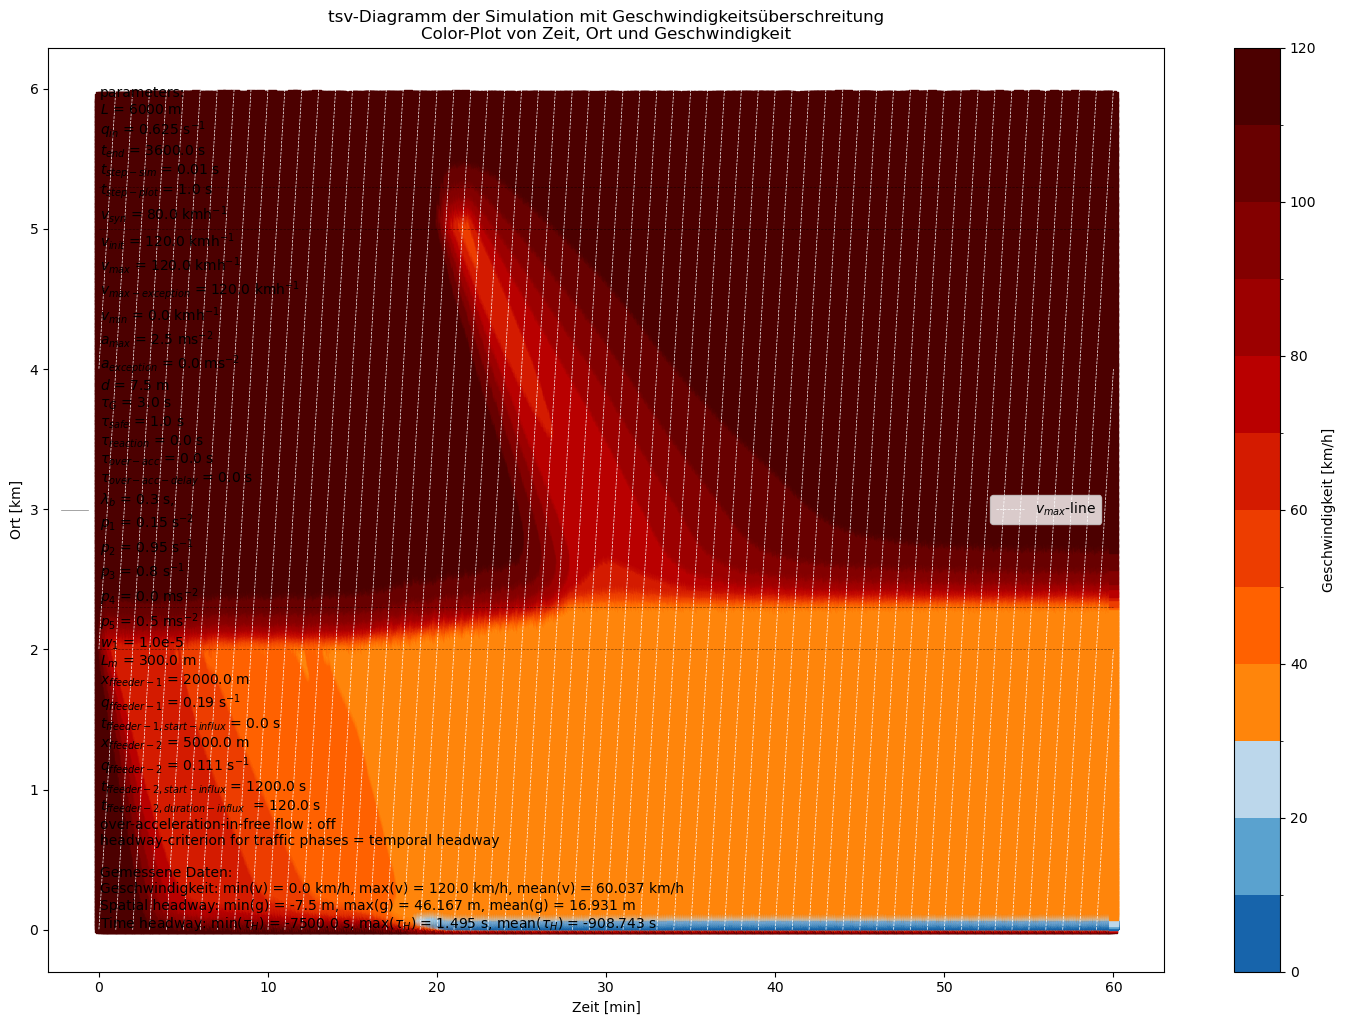

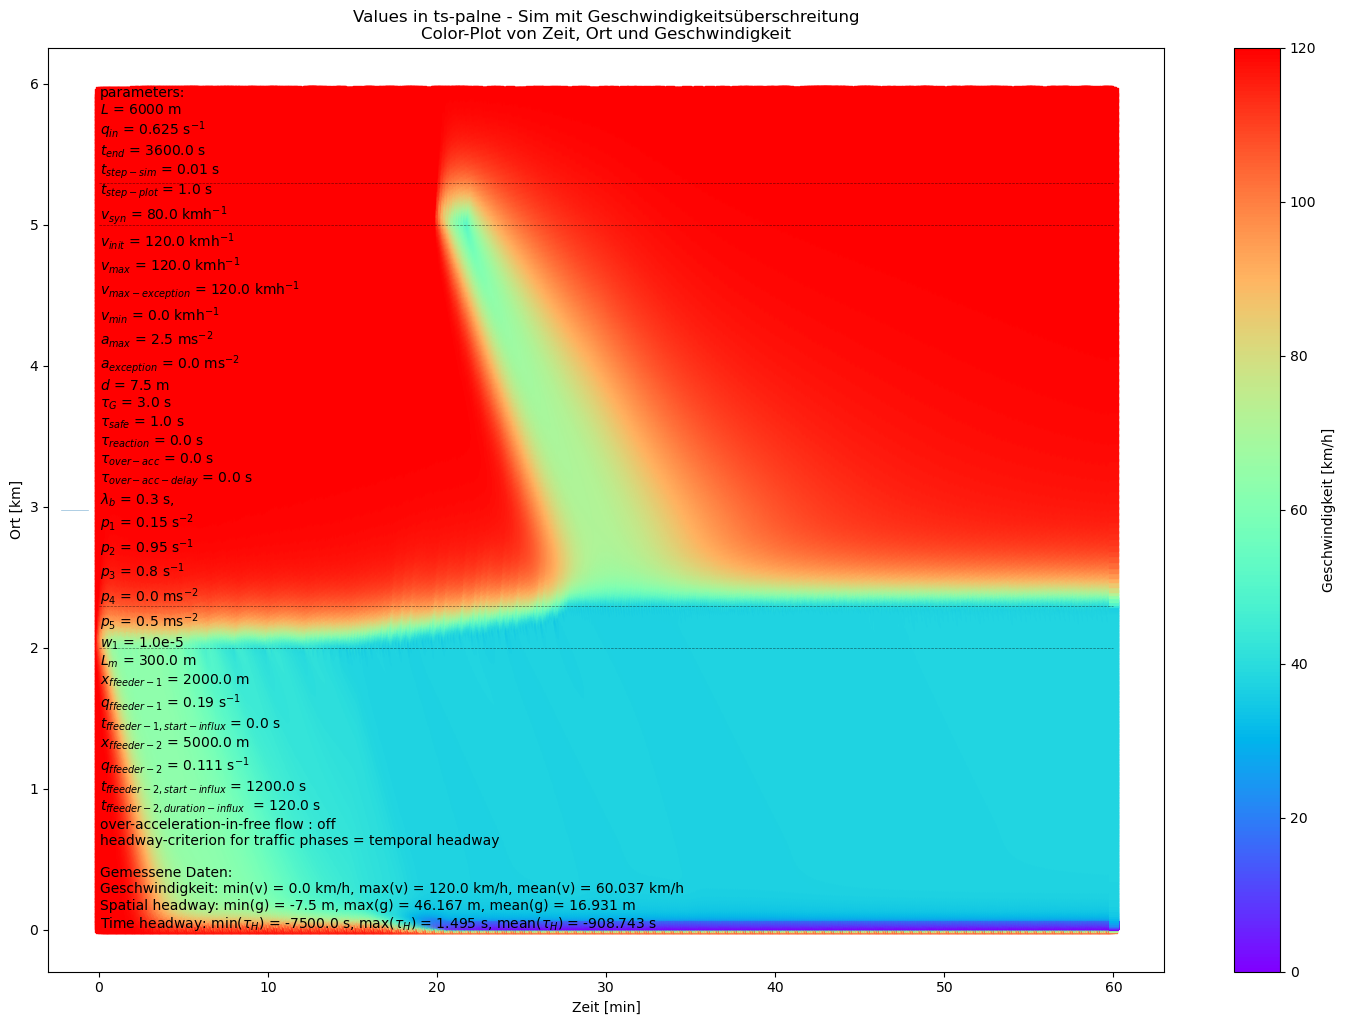

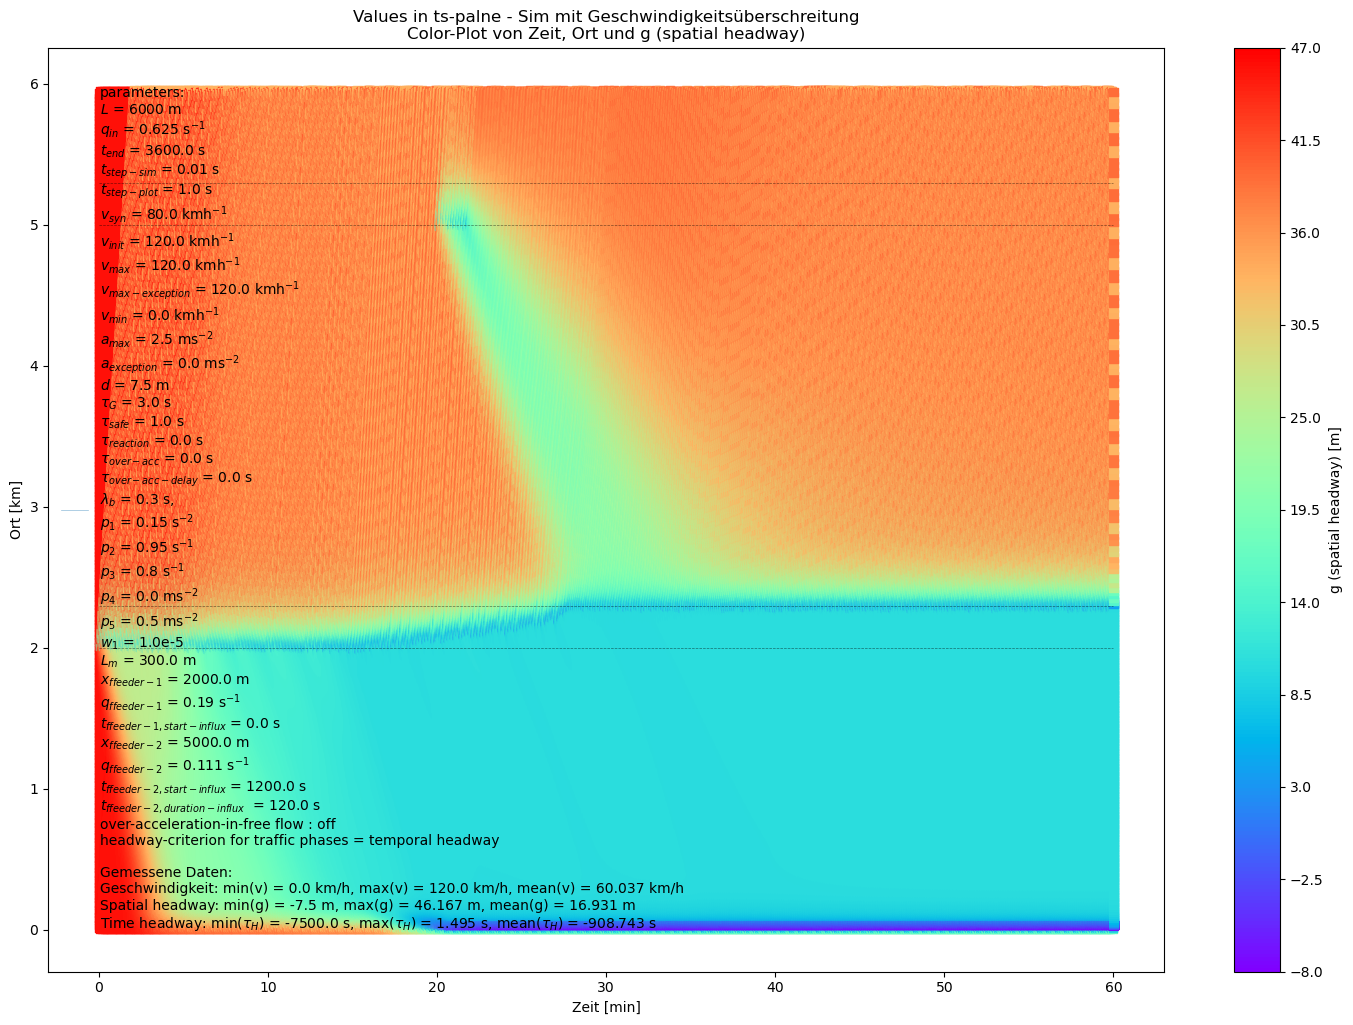

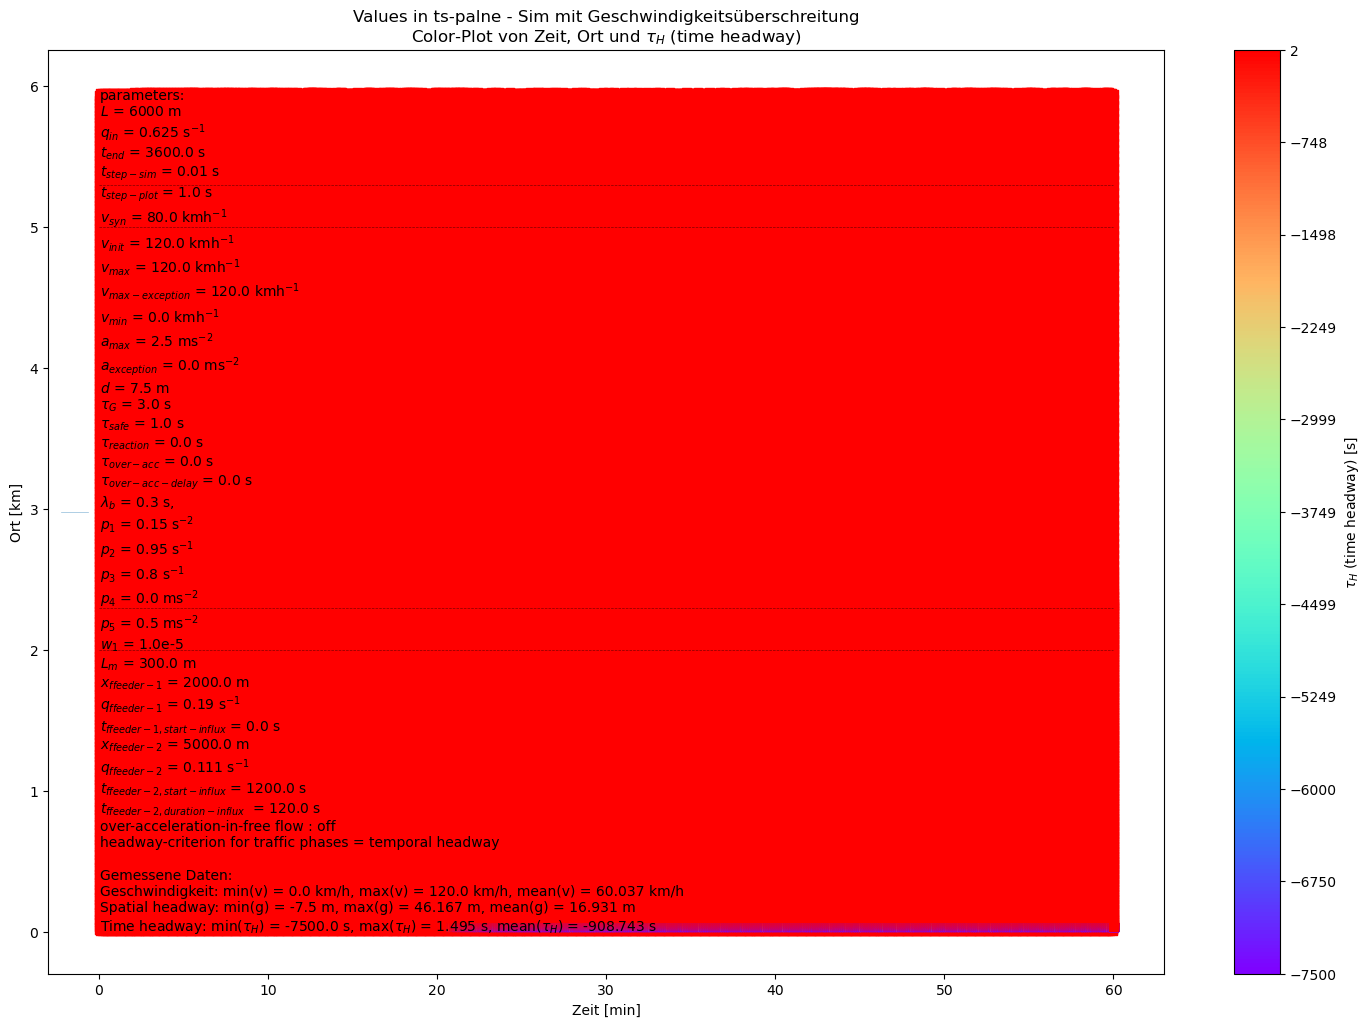

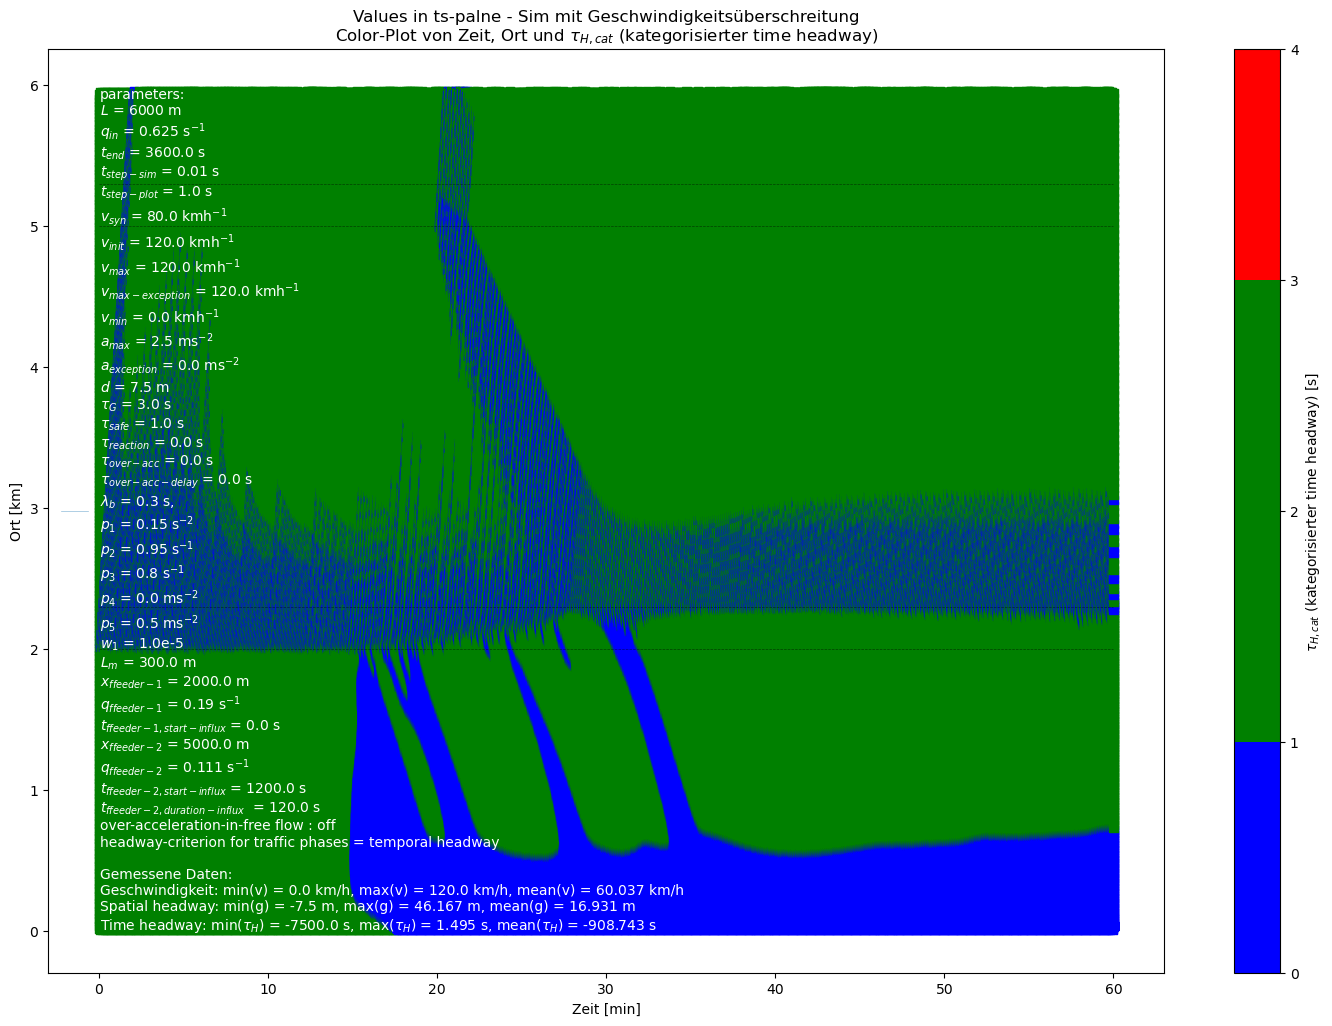

In [8]:
init_Startzeit = now()
println("init. Startzeit    = $init_Startzeit")
#include("Kerner_2023_functions vor v22.txt")
############################################################################################################
### Input-variablen
############################################################################################################
npt = Dict(
    :L_track         => 6*10^3, #6*10^3 # 10^4,
    :q_in            => 0.625, #0.29, #0.44, #0.57, #0.625, #0.4,
    
    :t_end           => 3600.0, #1200.0 #1800.0, #2400.0, #300.0, #2100.0 #1500.0 #1800.0 #3600.0 #6000.0 #7200.0
    :t_step_sim      => 0.01,
    :t_step_plot     => 1.0,

    :init_noise      => 0.0, #0.25, #0.0
# Damit der Fall des syncronisierten Verkehrs erhalten bleibt, muss immer nach der Zeit τ_in => (g_safe+d)/v_syn 
# ein Auto in die Straße fahren, dementsprechend ist q_in => 1 / τ_in. g_safe => 19,5 m; d => 7,5 m; 
# v_syn => (19 + 4/9) m/s
    :v_syn           => 22+2/9,
    :v_init          => 33+1/3,#22+2/9,
    :v_max           => 33+1/3,
    
    :v_max_exception => 33+1/3, #36+1/9, #38+8/9 m/s = 140 km/h , 36+1/9 m/s = 130 km/h
    :a_exception     => 0, #5+5/9,  # -> 5+5/9 m/s^2 = 20 km/h/s
    
    :v_min           => 0.0, #-(8+1/3), # besser: 0
    :a_max           => 2.5,
    :d_par           => 7.5,

    :τ_G             => 3.0, # 3.5
    :τ_safe          => 1.0, # 1.5
    :τ_reaction      => 0.0, #0.8, #1.0, #0.5, 0.6, 0.1
    :τ_over_acc      => 0.0, #0.2, #0.5, #0.2,
    :τ_oa_delay      => 0.0, #1
    :λ_b             => 0.3, #0.5, 0.7, # 0.3
# für τ_H < τ_safe gilt: a = p1 * (g-g_safe) + p2 * (v_ln - v_n)
    :p1              => 0.15,
    :p2              => 0.95,
# für τ_safe < τ_H < τ_G gilt: a = p3 * (v_ln - v_n) + p4 * Θ(v_n - v_syn)    
    :p3              => 0.8,
    :p4              => 0.0, # 1.0, # 0.5# p4 = 0.0 als Versuch 11.6.2024 im paper ist p4=1,
    :p5              => 0.0, # nachbesetzen in mainfunc -------------------------------------------------------
    :w1              => 0.0, # nachbesetzen in mainfunc -------------------------------------------------------
    
    :L_m             => 300.0,
    :x_zub           => Dict(
                            :x11 => 2000.0, #2000.0
                            :x12 => 0.0,  # nachbesetzen (s.u.) --------------------------------------------
                            :x21 => 5000.0, #5000.0
                            :x22 => 0.0), # nachbesetzen (s.u.) --------------------------------------------

    :q_zub           => Dict(
                            :q10 => 0.0,
                            :q11 => 685/3600, #0.25,
                            :q20 => 0.0,
                            :q21 => 1/9), # 400/3600
    
    :t_zub           => Dict(
                            :b1_start    => 0.0, #300.0, #600,
                            :b2_start    => 1200.0, #600,
                            :b2_duration => 120.0),

    :monitoring_oa_first_car   => 40, # als Integer angeben!
    :monitoring_oa_duration    => 60.0,
    :monitoring_oa_switch      => 0,    # Monitoring der Beschleunigung ein-/ausschalten
    :oa_in_fflow_switch        => 0,    # over-acceleration im free flow
    :monitoring_g_sum_shift    => 0,    # monitoring der Summe der g-werte
    :monitoring_road_occ_shift => 0,    # Monitoring der Besetzung der Straße
    #:monitoring_fill_zub_shift => 0,
    :monitoring_filling_levels_of_bnecks_shift         => 0,
    :monitoring_crictical_cars_by_zub_locations_switch => 0,

    :acc_fct_nr                => 2
)
npt[:x_zub][:x12] = npt[:x_zub][:x11] + npt[:L_m]
npt[:x_zub][:x22] = npt[:x_zub][:x21] + npt[:L_m]


##################################################################
### Stochastik: Input -Variablen
##################################################################
#p5_input_in = 0.2 ; #p5_input_in_vec = collect(0.1:0.1:1.0) ; #w1_input_in_vec = collect(0.1:0.1:0.9)
#p5_input_in_vec = collect(0.1:0.2:1.1) ; #w1_input_in_vec = collect(0.1:0.2:0.9)
p5_input_in_vec = [0.5] #[0.2] #1 , 0.2 #[0.0, 0.5] #[4.0]
w1_input_in_vec = [1e-5] #[1e-5] #[1e-5] #1e-5, 1e-4 #[0.01] #[0.0, 0.01] #[0.01]# , 0.02]


#########################################################################################
now_time = Dates.now()
# Datum- und Uhrzeitformat für den Dateinamen festlegen
date_time_format = DateFormat("yyyy-mm-dd_HH-MM-SS")
# Datum und Uhrzeit formatieren
date_time_string = Dates.format(now_time, date_time_format)

# Gib den Pfad zum neuen Ordner an
#ordner_pfad = "C:/Users/Fliese/Desktop/MA Stau/Sims/Kerner23 1lane zeitverzögert bottleneck oa stoch/some images/"*
#"Sim mit Verzögerung $date_time_string"
ordner_pfad = "./Sim mit Verzögerung $date_time_string"

pth = Dict(
    :o1 => ordner_pfad,
    :o2 => ordner_pfad*"/v in ts-plane",
    :o3 => ordner_pfad*"/τH in ts-plane",
    :o4 => ordner_pfad*"/τHcat in ts-plane",
    :o5 => ordner_pfad*"/g in ts-plane"
)
pth[:o1]
# Erstelle den neuen Ordner
mkdir(pth[:o1])
mkdir(pth[:o2])
mkdir(pth[:o3])
mkdir(pth[:o4])
mkdir(pth[:o5])
#########################################################################################
# Teststring abspeichern
testy_string = "Test-string."
open(pth[:o1]*"/test_datei.txt", "w") do file
    write(file, testy_string)
end

########################################################################

number = 0
total_number = length(p5_input_in_vec) * length(w1_input_in_vec)
println("p5_input_in_vec = $p5_input_in_vec, w1_input_in_vec = $w1_input_in_vec")
println("total_number = $total_number")
#min_v_kmh_vec  = []
#max_v_kmh_vec  = []
#mean_v_kmh_vec = []
#min_g_vec      = []
#min_τ_H_vec    = []

τ_H_plot_t_vals_ex  = []
τ_H_plot_s_vals_ex  = []
τ_H_plot_τ_vals2_ex = []

information_string = "Zusammenfassung\n"*"p5_input_in_vec = $p5_input_in_vec , w1_input_in_vec = $w1_input_in_vec\n\n"

for p5_input_in in p5_input_in_vec
    for w1_input_in in w1_input_in_vec
        number = number + 1
        println("\n\n"*"Simulation $number von $total_number: p5_input_in = $p5_input_in,  w1_input_in = $w1_input_in")
        summary_dct, String_on_zub_locations, String_Zufahrt_der_Autos = Kerner2023main_func(
            npt, pth, p5_input_in, w1_input_in)
        
        #push!(min_v_kmh_vec , min_v_kmh_ex)
        #push!(mean_v_kmh_vec , mean_v_kmh_ex)
        #push!(max_v_kmh_vec , max_v_kmh_ex)
        #push!(min_g_vec , min_g_ex)
        #push!(min_τ_H_vec , min_τ_H_ex)
        
        # Sortiere die Schlüssel des Dictionaries alphabetisch
        sortierte_schluessel = sort(collect(keys(summary_dct)))

        # Erzeuge eine Liste von Strings, die die Schlüssel-Wert-Paare in der sortierten Reihenfolge repräsentieren
        paare = [string(key) * " = " * string(summary_dct[key]) for key in sortierte_schluessel]

        # Verbinde die Paare mit ", " zu einem einzigen String
        #string_summary_dct = join(paare, ", ")
        
        # Funktion zum Einfügen von Zeilenumbrüchen nach dem 2., 5., 8., 11., ... Element
        #string_summary_dct = insert_line_breaks(paare)
        string_summary_dct = insert_line_breaks_and_units(paare)
        
        information_string *= "p5_input_in = $p5_input_in , w1_input_in = $w1_input_in\n"*
            string_summary_dct*
            "\n\n$String_on_zub_locations\n\n$String_Zufahrt_der_Autos\n\n\n"
    end
end

###########################################################################
## Zusammenfassung in txt-Datei abspeichern
###################################################################
final_jetzt = now()
information_string *= ("init_Startzeit = $init_Startzeit\n"*"final_jetzt    = $final_jetzt")
# Öffne die Datei im Schreibmodus und schreibe den String hinein
open(pth[:o1]*"/Zusammenfassung.txt", "w") do file2
    write(file2, information_string)
end
#final_jetzt = now()
println("done - $final_jetzt")
#println("minimum(v) = $(minimum(min_v_kmh_vec)) km/h")

In [9]:
# Probleme für t_reaction = 0.3 , p5_input_in = 4.0,  w1_input_in = 0.01-> negative x_Werte